# Car Price Prediction - Complete Data Processing & Exploration Pipeline

## Overview

This notebook demonstrates a complete data processing pipeline combining:
1. **Brand Standardization** using ProductionCarMatcher
2. **Feature Engineering** using DataPreprocessor  
3. **Comprehensive Exploration** of cleaned data

## Pipeline Steps

1. **Quick Data Cleaning**
   - Brand/Model standardization with ProductionCarMatcher
   - Feature preprocessing with DataPreprocessor
2. **Cleaned Data Exploration**
   - Statistical analysis of processed features
   - Quality assessment post-cleaning
   - Feature relationships and insights
3. **Processing Validation**
   - Before/after comparisons
   - Data quality improvements
   - Feature engineering impact

## Data Sources
- Training dataset: Car price prediction data
- Reference database: Kaggle Global Car Make and Model List

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Download and processing libraries
import kagglehub
from wordcloud import WordCloud
from scipy import stats

# Load our custom classes
os.chdir('/Users/leonardodicaterina/Documents/GitHub/ML_group_45')
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

print("=== LOADING DATASETS ===")

# Load car price datasets
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

# Download Kaggle car database for brand standardization
print("\nDownloading Kaggle car database...")
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
file_path = os.path.join(path, 'vehicle models.json')

with open(file_path, 'r') as f:
    kaggle_car_data = json.load(f)

print(f"Reference database loaded: {len(kaggle_car_data)} manufacturers")

# Show original data sample
print("\n=== ORIGINAL DATA SAMPLE ===")
display(train_data.head())

# Original data quality assessment
print(f"\nOriginal Data Quality:")
print(f"  Missing values: {train_data.isnull().sum().sum()}")
print(f"  Rows with missing data: {train_data.isnull().any(axis=1).sum()}")
print(f"  Unique brands: {train_data['Brand'].nunique()}")
print(f"  Unique models: {train_data['model'].nunique()}")

=== LOADING DATASETS ===
Training data: (75973, 14)
Test data: (32567, 13)

Reference database loaded: 144 manufacturers

=== ORIGINAL DATA SAMPLE ===


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0



Original Data Quality:
  Missing values: 30993
  Rows with missing data: 21524
  Unique brands: 72
  Unique models: 735


In [2]:
print("STEP 1: BRAND STANDARDIZATION WITH PRODUCTIONCARMATCHES")
print("=" * 60)

# Create optimized database
print("Creating optimized car database...")
optimized_db = create_optimized_database(kaggle_car_data, max_model_words=3)

# Initialize matcher
print("Initializing ProductionCarMatcher...")
matcher = ProductionCarMatcher(optimized_db)

print(f"Database ready: {len(optimized_db)} manufacturers")

# Clean brands in training data
print("\nCleaning brands in training data...")
train_cleaned_brands = []
train_brand_confidences = []

for brand in train_data['Brand']:
    match, confidence = matcher.find_best_make_match(brand)
    train_cleaned_brands.append(match)
    train_brand_confidences.append(confidence)

# Clean brands in test data
print("Cleaning brands in test data...")
test_cleaned_brands = []
test_brand_confidences = []

for brand in test_data['Brand']:
    match, confidence = matcher.find_best_make_match(brand)
    test_cleaned_brands.append(match)
    test_brand_confidences.append(confidence)

# Add cleaned brands to datasets
train_data_step1 = train_data.copy()
train_data_step1['Brand_cleaned'] = train_cleaned_brands
train_data_step1['Brand_confidence'] = train_brand_confidences

test_data_step1 = test_data.copy()
test_data_step1['Brand_cleaned'] = test_cleaned_brands
test_data_step1['Brand_confidence'] = test_brand_confidences

# Show brand cleaning results
print(f"\nBrand Cleaning Results:")
print(f"  Train brands: {train_data['Brand'].nunique()} → {train_data_step1['Brand_cleaned'].nunique()}")
print(f"  Test brands: {test_data['Brand'].nunique()} → {test_data_step1['Brand_cleaned'].nunique()}")
print(f"  Train avg confidence: {np.mean(train_brand_confidences):.1f}%")
print(f"  Test avg confidence: {np.mean(test_brand_confidences):.1f}%")

# Show top cleaning examples
print(f"\nTop Brand Standardizations:")
brand_examples = train_data_step1[['Brand', 'Brand_cleaned', 'Brand_confidence']].drop_duplicates()
brand_examples = brand_examples.sort_values('Brand_confidence', ascending=False).head(10)
for _, row in brand_examples.iterrows():
    if row['Brand'] != row['Brand_cleaned']:
        print(f"  '{row['Brand']}' → '{row['Brand_cleaned']}' ({row['Brand_confidence']}%)")

STEP 1: BRAND STANDARDIZATION WITH PRODUCTIONCARMATCHES
Creating optimized car database...
Analyzing word frequencies...
Created optimized database with 146 makes
Initializing ProductionCarMatcher...
Database ready: 146 manufacturers

Cleaning brands in training data...
Cleaning brands in test data...

Brand Cleaning Results:
  Train brands: 72 → 12
  Test brands: 64 → 13
  Train avg confidence: 98.0%
  Test avg confidence: 98.0%

Top Brand Standardizations:
  'VW' → 'volkswagen' (100.0%)
  'PEL' → 'opel' (100.0%)
  'KODA' → 'skoda' (100.0%)
  'aud' → 'audi' (100.0%)
  'SKOD' → 'skoda' (100.0%)
  'for' → 'ford' (100.0%)
  'v' → 'avanti motor corporation' (100.0%)
  'kod' → 'skoda' (100.0%)
  'HYUNDAI' → 'hyundai' (100.0%)


In [3]:
print("STEP 2: FEATURE PREPROCESSING WITH DATAPREPROCESSOR")
print("=" * 60)

# Initialize preprocessor
preprocessor = DataPreprocessor(target_column='price')

# Define transformation functions
def log_transform(x):
    """Safe log transformation"""
    return np.log1p(np.abs(x))

def year_to_age(year_series):
    """Convert year to car age"""
    return 2025 - year_series

def normalize_paint_quality(paint_series):
    """Normalize paint quality to 0-1 range"""
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine_size(engine_series):
    """Convert small engine sizes from liters to cc"""
    # If engine size <= 10, assume it's in liters and convert to cc
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result

# Configure comprehensive preprocessing pipeline
feature_configs = {
    # Numerical features with transformations
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr',
        'transform_func': log_transform,
        'scaling_method': 'standard'
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age,
        'scaling_method': 'minmax'
    },
    'engineSize': {
        'missing_strategy': 1600,
        'transform_func': normalize_engine_size,
        'scaling_method': 'robust'
    },
    'tax': {
        'missing_strategy': 'median',
        'scaling_method': 'standard'
    },
    'mpg': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr',
        'scaling_method': 'standard'
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint_quality,
        'scaling_method': 'minmax'
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard'
    },
    'hasDamage': {
        'missing_strategy': 1,  # Assume damaged if unknown
        'scaling_method': None
    },
    
    # Categorical features with encoding
    'Brand_cleaned': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # Target encoding for high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'
    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'
    }
}

print("Configuring preprocessing pipeline...")
for feature, config in feature_configs.items():
    if feature in train_data_step1.columns:
        preprocessor.add_feature_pipeline(feature, **config)
        print(f"  ✓ {feature}: {config}")

# Fit preprocessor on training data
print(f"\nFitting preprocessor on training data...")
preprocessor.fit(train_data_step1)

# Transform both datasets
print("Transforming training data...")
X_train_processed, y_train_processed = preprocessor.transform(train_data_step1)

print("Transforming test data...")
X_test_processed, y_test_processed = preprocessor.transform(test_data_step1)

# Show preprocessing results
print(f"\nPreprocessing Results:")
print(f"  Original features: {len(feature_configs)}")
print(f"  Final features: {X_train_processed.shape[1]}")
print(f"  Training data: {X_train_processed.shape}")
print(f"  Test data: {X_test_processed.shape}")
print(f"  Missing values after processing: {X_train_processed.isnull().sum().sum()}")

print(f"\nFinal feature set:")
print(f"  {list(X_train_processed.columns)}")

STEP 2: FEATURE PREPROCESSING WITH DATAPREPROCESSOR
Configuring preprocessing pipeline...
  ✓ mileage: {'missing_strategy': 'median', 'outlier_method': 'iqr', 'transform_func': <function log_transform at 0x1673823e0>, 'scaling_method': 'standard'}
  ✓ year: {'missing_strategy': 'mean', 'transform_func': <function year_to_age at 0x167382480>, 'scaling_method': 'minmax'}
  ✓ engineSize: {'missing_strategy': 1600, 'transform_func': <function normalize_engine_size at 0x1673825c0>, 'scaling_method': 'robust'}
  ✓ tax: {'missing_strategy': 'median', 'scaling_method': 'standard'}
  ✓ mpg: {'missing_strategy': 'median', 'outlier_method': 'iqr', 'scaling_method': 'standard'}
  ✓ paintQuality%: {'missing_strategy': 'median', 'transform_func': <function normalize_paint_quality at 0x167382520>, 'scaling_method': 'minmax'}
  ✓ previousOwners: {'missing_strategy': 'median', 'transform_func': <function <lambda> at 0x167382660>, 'scaling_method': 'standard'}
  ✓ hasDamage: {'missing_strategy': 1, 'sca

In [4]:
print("CREATING HELPER FUNCTIONS FOR STANDARDIZED EXPLORATION")
print("=" * 60)

def analyze_processed_numerical_feature(processed_df, original_df, feature_name, 
                                       processed_feature_name=None, target_col='price'):
    """
    Comprehensive analysis of processed numerical features
    
    Args:
        processed_df: DataFrame with processed features
        original_df: Original DataFrame for comparison
        feature_name: Original feature name
        processed_feature_name: Name in processed DataFrame (if different)
        target_col: Target column for correlation analysis
    """
    
    if processed_feature_name is None:
        processed_feature_name = feature_name
    
    print(f"\n{'='*60}")
    print(f"PROCESSED NUMERICAL ANALYSIS: {feature_name.upper()}")
    print(f"{'='*60}")
    
    # Get processed and original data
    if processed_feature_name in processed_df.columns:
        processed_data = processed_df[processed_feature_name].dropna()
    else:
        print(f"⚠️  Feature '{processed_feature_name}' not found in processed data")
        return None
    
    original_data = original_df[feature_name].dropna() if feature_name in original_df.columns else None
    
    # Basic statistics comparison
    print("=== PROCESSING IMPACT COMPARISON ===")
    
    if original_data is not None:
        print("ORIGINAL DATA:")
        print(f"  Count: {len(original_data):,}")
        print(f"  Missing: {original_df[feature_name].isnull().sum():,}")
        print(f"  Range: [{original_data.min():.3f}, {original_data.max():.3f}]")
        print(f"  Mean: {original_data.mean():.3f}")
        print(f"  Std: {original_data.std():.3f}")
        print(f"  Skewness: {original_data.skew():.3f}")
    
    print("\nPROCESSED DATA:")
    print(f"  Count: {len(processed_data):,}")
    print(f"  Missing: {processed_df[processed_feature_name].isnull().sum():,}")
    print(f"  Range: [{processed_data.min():.3f}, {processed_data.max():.3f}]")
    print(f"  Mean: {processed_data.mean():.3f}")
    print(f"  Std: {processed_data.std():.3f}")
    print(f"  Skewness: {processed_data.skew():.3f}")
    
    # Data quality improvements
    print("\n=== DATA QUALITY IMPROVEMENTS ===")
    if original_data is not None:
        original_missing = original_df[feature_name].isnull().sum()
        processed_missing = processed_df[processed_feature_name].isnull().sum()
        print(f"  Missing values: {original_missing} → {processed_missing}")
        
        # Outlier comparison (using IQR method)
        def count_outliers(data):
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            return ((data < lower) | (data > upper)).sum()
        
        original_outliers = count_outliers(original_data)
        processed_outliers = count_outliers(processed_data)
        print(f"  Outliers (IQR): {original_outliers} → {processed_outliers}")
        
        # Normality improvement (using skewness)
        skew_improvement = abs(original_data.skew()) - abs(processed_data.skew())
        print(f"  Skewness improvement: {skew_improvement:.3f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Distribution comparison
    if original_data is not None:
        axes[0,0].hist(original_data, bins=50, alpha=0.7, color='lightcoral', label='Original')
        axes[0,0].set_title(f'{feature_name} - Original Distribution')
        axes[0,0].set_xlabel(feature_name)
        axes[0,0].set_ylabel('Frequency')
    
    axes[0,1].hist(processed_data, bins=50, alpha=0.7, color='lightblue', label='Processed')
    axes[0,1].set_title(f'{processed_feature_name} - Processed Distribution')
    axes[0,1].set_xlabel(processed_feature_name)
    axes[0,1].set_ylabel('Frequency')
    
    # Q-Q plots for normality assessment
    if original_data is not None:
        stats.probplot(original_data, dist="norm", plot=axes[0,2])
        axes[0,2].set_title(f'{feature_name} - Original Q-Q Plot')
    
    stats.probplot(processed_data, dist="norm", plot=axes[1,0])
    axes[1,0].set_title(f'{processed_feature_name} - Processed Q-Q Plot')
    
    # Box plots comparison
    if original_data is not None:
        axes[1,1].boxplot(original_data, labels=['Original'])
        axes[1,1].set_title(f'{feature_name} - Distribution Comparison')
        axes[1,1].set_ylabel('Values')
        
    if processed_data is not None:
        axes[1,2].boxplot(processed_data, labels=['Processed'])
        axes[1,2].set_title(f'{feature_name} - Distribution Comparison')
        axes[1,2].set_ylabel('Values')
    

    plt.tight_layout()
    plt.show()
    
    # Feature engineering insights
    print("\n=== FEATURE ENGINEERING INSIGHTS ===")
    if abs(processed_data.skew()) < 0.5:
        print("✓ Distribution is now approximately normal")
    elif abs(processed_data.skew()) < 1.0:
        print("✓ Distribution is moderately skewed (acceptable)")
    else:
        print("⚠️  Distribution still highly skewed - consider additional transformations")
    
    if processed_df[processed_feature_name].isnull().sum() == 0:
        print("✓ No missing values after preprocessing")
    
    # Return summary statistics
    return {
        'processed_stats': {
            'count': len(processed_data),
            'mean': processed_data.mean(),
            'std': processed_data.std(),
            'skewness': processed_data.skew(),
            'missing': processed_df[processed_feature_name].isnull().sum()
        },
        'correlation_with_target': correlation if target_col in processed_df.columns else None
    }


def analyze_processed_categorical_feature(processed_df, original_df, feature_name, 
                                        processed_feature_name=None, target_col='price'):
    """
    Comprehensive analysis of processed categorical features
    
    Args:
        processed_df: DataFrame with processed features  
        original_df: Original DataFrame for comparison
        feature_name: Original feature name
        processed_feature_name: Name in processed DataFrame (if different)
        target_col: Target column for relationship analysis
    """
    
    if processed_feature_name is None:
        processed_feature_name = feature_name
    
    print(f"\n{'='*60}")
    print(f"PROCESSED CATEGORICAL ANALYSIS: {feature_name.upper()}")
    print(f"{'='*60}")
    
    # Check if feature was encoded (multiple columns)
    encoded_cols = [col for col in processed_df.columns if col.startswith(f"{processed_feature_name}_")]
    is_encoded = len(encoded_cols) > 0
    
    # Original data analysis
    if feature_name in original_df.columns:
        original_data = original_df[feature_name]
        original_unique = original_data.nunique()
        original_missing = original_data.isnull().sum()
        original_counts = original_data.value_counts(dropna=False)
        
        print("=== ORIGINAL DATA SUMMARY ===")
        print(f"  Total records: {len(original_data):,}")
        print(f"  Unique values: {original_unique:,}")
        print(f"  Missing values: {original_missing:,} ({original_missing/len(original_data)*100:.2f}%)")
        print(f"  Most common: '{original_counts.index[0]}' ({original_counts.iloc[0]:,} occurrences)")
    
    # Processed data analysis
    print("\n=== PROCESSED DATA SUMMARY ===")
    
    if is_encoded:
        print(f"  Encoding method: One-hot encoding")
        print(f"  Original feature → {len(encoded_cols)} binary features")
        print(f"  Encoded columns: {encoded_cols}")
        
        # Check for missing values in encoded columns
        encoded_missing = processed_df[encoded_cols].isnull().sum().sum()
        print(f"  Missing values after encoding: {encoded_missing}")
        
        # Show encoding statistics
        print(f"\n  Encoding distribution:")
        for col in encoded_cols[:10]:  # Show first 10 to avoid clutter
            count = processed_df[col].sum()
            print(f"    {col}: {count:,} occurrences")
        if len(encoded_cols) > 10:
            print(f"    ... and {len(encoded_cols) - 10} more columns")
            
    elif processed_feature_name in processed_df.columns:
        processed_data = processed_df[processed_feature_name]
        processed_missing = processed_data.isnull().sum()
        
        print(f"  Encoding method: Target/Mean encoding")
        print(f"  Missing values: {processed_missing}")
        print(f"  Value range: [{processed_data.min():.3f}, {processed_data.max():.3f}]")
        print(f"  Mean: {processed_data.mean():.3f}")
        print(f"  Std: {processed_data.std():.3f}")
    
    # Data quality improvements
    print("\n=== PROCESSING IMPROVEMENTS ===")
    if feature_name in original_df.columns:
        if is_encoded:
            print("✓ Converted to binary features (suitable for ML algorithms)")
            print("✓ Eliminated ordinality assumptions")
            if encoded_missing == 0:
                print("✓ No missing values after encoding")
        else:
            print("✓ Converted to numerical encoding")
            print("✓ Preserved relationship with target variable")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original distribution (if available)
    if feature_name in original_df.columns:
        top_categories = original_counts.head(15)
        axes[0,0].bar(range(len(top_categories)), top_categories.values, color='lightcoral')
        axes[0,0].set_xticks(range(len(top_categories)))
        axes[0,0].set_xticklabels(top_categories.index, rotation=45, ha='right')
        axes[0,0].set_title(f'{feature_name} - Original Distribution (Top 15)')
        axes[0,0].set_ylabel('Count')
    
    # Processed feature analysis
    if is_encoded:
        # Show sum of each encoded column
        encoded_sums = processed_df[encoded_cols].sum().sort_values(ascending=False).head(15)
        axes[0,1].bar(range(len(encoded_sums)), encoded_sums.values, color='lightblue')
        axes[0,1].set_xticks(range(len(encoded_sums)))
        axes[0,1].set_xticklabels([col.replace(f"{processed_feature_name}_", "") for col in encoded_sums.index], 
                                 rotation=45, ha='right')
        axes[0,1].set_title(f'{processed_feature_name} - Encoded Features (Top 15)')
        axes[0,1].set_ylabel('Count')
        
    elif processed_feature_name in processed_df.columns:
        # Distribution of encoded values
        axes[0,1].hist(processed_df[processed_feature_name].dropna(), bins=30, color='lightblue', alpha=0.7)
        axes[0,1].set_title(f'{processed_feature_name} - Encoded Distribution')
        axes[0,1].set_xlabel('Encoded Value')
        axes[0,1].set_ylabel('Frequency')
    
    # Missing values comparison
    if feature_name in original_df.columns:
        missing_comparison = [original_missing, 
                            encoded_missing if is_encoded else processed_df[processed_feature_name].isnull().sum()]
        axes[1,0].bar(['Original', 'Processed'], missing_comparison, color=['lightcoral', 'lightblue'])
        axes[1,0].set_title('Missing Values Comparison')
        axes[1,0].set_ylabel('Count')
    
    # Target relationship (if available and not one-hot encoded)
    if target_col in processed_df.columns and not is_encoded and processed_feature_name in processed_df.columns:
        feature_target = processed_df[[processed_feature_name, target_col]].dropna()
        if len(feature_target) > 0:
            axes[1,1].scatter(feature_target[processed_feature_name], feature_target[target_col], 
                             alpha=0.5, color='green')
            correlation = feature_target[processed_feature_name].corr(feature_target[target_col])
            axes[1,1].set_xlabel(f'{processed_feature_name} (Encoded)')
            axes[1,1].set_ylabel(target_col)
            axes[1,1].set_title(f'Encoded Feature vs {target_col}\nCorrelation: {correlation:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # Return summary
    summary = {
        'encoding_type': 'onehot' if is_encoded else 'target',
        'original_cardinality': original_unique if feature_name in original_df.columns else None,
        'processed_features': len(encoded_cols) if is_encoded else 1,
        'missing_values_handled': True if (is_encoded and encoded_missing == 0) or 
                                         (not is_encoded and processed_df[processed_feature_name].isnull().sum() == 0) else False
    }
    
    if not is_encoded and processed_feature_name in processed_df.columns and target_col in processed_df.columns:
        feature_target = processed_df[[processed_feature_name, target_col]].dropna()
        if len(feature_target) > 0:
            summary['target_correlation'] = feature_target[processed_feature_name].corr(feature_target[target_col])
    
    return summary


def create_processing_summary_dashboard(processed_df, original_df, feature_configs):
    """
    Create a comprehensive dashboard showing the impact of all preprocessing steps
    """
    
    print(f"\n{'='*60}")
    print("COMPLETE PREPROCESSING IMPACT DASHBOARD")
    print(f"{'='*60}")
    
    # Overall statistics
    print("\n=== OVERALL PREPROCESSING IMPACT ===")
    print(f"Original features: {len(feature_configs)}")
    print(f"Final features: {processed_df.shape[1]}")
    print(f"Feature expansion ratio: {processed_df.shape[1]/len(feature_configs):.2f}x")
    print(f"Original missing values: {original_df.isnull().sum().sum():,}")
    print(f"Final missing values: {processed_df.isnull().sum().sum():,}")
    print(f"Data completeness: {(1 - processed_df.isnull().sum().sum()/(processed_df.shape[0]*processed_df.shape[1]))*100:.1f}%")
    
    # Feature type summary
    numerical_features = processed_df.select_dtypes(include=[np.number]).columns
    categorical_features = processed_df.select_dtypes(include=['object']).columns
    
    print(f"\n=== FINAL FEATURE COMPOSITION ===")
    print(f"Numerical features: {len(numerical_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    
    # 1. Missing values before/after
    original_missing = original_df.isnull().sum()
    processed_missing = processed_df.isnull().sum()
    
    axes[0,0].bar(['Original', 'Processed'], 
                 [original_missing.sum(), processed_missing.sum()], 
                 color=['lightcoral', 'lightgreen'])
    axes[0,0].set_title('Total Missing Values')
    axes[0,0].set_ylabel('Count')
    
    # 2. Feature count comparison
    axes[0,1].bar(['Original', 'Processed'], 
                 [len(feature_configs), processed_df.shape[1]], 
                 color=['lightcoral', 'lightblue'])
    axes[0,1].set_title('Feature Count')
    axes[0,1].set_ylabel('Number of Features')
    
    # 3. Data completeness by feature (top features with most improvement)
    feature_improvements = {}
    for feature in feature_configs.keys():
        if feature in original_df.columns:
            original_complete = (len(original_df) - original_df[feature].isnull().sum()) / len(original_df)
            # Find corresponding processed feature(s)
            processed_cols = [col for col in processed_df.columns if col.startswith(feature)]
            if processed_cols:
                processed_complete = min([(len(processed_df) - processed_df[col].isnull().sum()) / len(processed_df) 
                                        for col in processed_cols])
                feature_improvements[feature] = processed_complete - original_complete
    
    top_improvements = sorted(feature_improvements.items(), key=lambda x: x[1], reverse=True)[:10]
    if top_improvements:
        features, improvements = zip(*top_improvements)
        axes[0,2].barh(range(len(features)), improvements, color='lightgreen')
        axes[0,2].set_yticks(range(len(features)))
        axes[0,2].set_yticklabels(features)
        axes[0,2].set_title('Data Completeness Improvement')
        axes[0,2].set_xlabel('Improvement Ratio')
    
    # 4. Distribution examples - show a few key numerical features
    numerical_original = [col for col in ['price', 'mileage', 'year'] if col in original_df.columns]
    for i, feature in enumerate(numerical_original[:3]):
        row, col = 1, i
        if feature in original_df.columns:
            axes[row,col].hist(original_df[feature].dropna(), bins=30, alpha=0.7, 
                             color='lightcoral', label='Original')
            # Find processed version
            processed_feature = feature
            if feature not in processed_df.columns:
                # Look for transformed version
                possible_names = [col for col in processed_df.columns if feature in col]
                if possible_names:
                    processed_feature = possible_names[0]
            
            if processed_feature in processed_df.columns:
                axes[row,col].hist(processed_df[processed_feature].dropna(), bins=30, alpha=0.7, 
                                 color='lightblue', label='Processed')
            
            axes[row,col].set_title(f'{feature} Distribution Comparison')
            axes[row,col].legend()
    
    # 5. Correlation heatmap of final numerical features
    if len(numerical_features) > 1:
        correlation_matrix = processed_df[numerical_features].corr()
        im = axes[2,0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
        axes[2,0].set_xticks(range(len(numerical_features)))
        axes[2,0].set_yticks(range(len(numerical_features)))
        axes[2,0].set_xticklabels(numerical_features, rotation=45, ha='right')
        axes[2,0].set_yticklabels(numerical_features)
        axes[2,0].set_title('Final Feature Correlations')
        plt.colorbar(im, ax=axes[2,0])
    
    # 6. Feature importance based on target correlation (if target exists)
    target_col = 'price'
    if target_col in processed_df.columns:
        correlations = {}
        for col in numerical_features:
            if col != target_col:
                corr = processed_df[col].corr(processed_df[target_col])
                if not np.isnan(corr):
                    correlations[col] = abs(corr)
        
        if correlations:
            sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]
            features, corr_values = zip(*sorted_corr)
            axes[2,1].barh(range(len(features)), corr_values, color='orange')
            axes[2,1].set_yticks(range(len(features)))
            axes[2,1].set_yticklabels(features)
            axes[2,1].set_title(f'Feature Correlation with {target_col}')
            axes[2,1].set_xlabel('Absolute Correlation')
    
    # 7. Processing method summary
    processing_methods = {}
    for feature, config in feature_configs.items():
        if 'encoding_method' in config:
            method = f"Encoding: {config['encoding_method']}"
        elif 'transform_func' in config:
            method = "Numerical transformation"
        else:
            method = "Basic preprocessing"
        
        processing_methods[method] = processing_methods.get(method, 0) + 1
    
    axes[2,2].pie(processing_methods.values(), labels=processing_methods.keys(), autopct='%1.1f%%')
    axes[2,2].set_title('Preprocessing Methods Used')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'original_features': len(feature_configs),
        'final_features': processed_df.shape[1],
        'expansion_ratio': processed_df.shape[1]/len(feature_configs),
        'missing_values_eliminated': original_df.isnull().sum().sum() - processed_df.isnull().sum().sum(),
        'data_completeness': (1 - processed_df.isnull().sum().sum()/(processed_df.shape[0]*processed_df.shape[1]))*100
    }

print("✓ Helper functions created successfully!")
print("  - analyze_processed_numerical_feature()")
print("  - analyze_processed_categorical_feature()")  
print("  - create_processing_summary_dashboard()")

CREATING HELPER FUNCTIONS FOR STANDARDIZED EXPLORATION
✓ Helper functions created successfully!
  - analyze_processed_numerical_feature()
  - analyze_processed_categorical_feature()
  - create_processing_summary_dashboard()


STEP 3: OVERALL PROCESSING IMPACT ASSESSMENT

COMPLETE PREPROCESSING IMPACT DASHBOARD

=== OVERALL PREPROCESSING IMPACT ===
Original features: 11
Final features: 15
Feature expansion ratio: 1.36x
Original missing values: 32,514
Final missing values: 3,038
Data completeness: 99.7%

=== FINAL FEATURE COMPOSITION ===
Numerical features: 13
Categorical features: 2


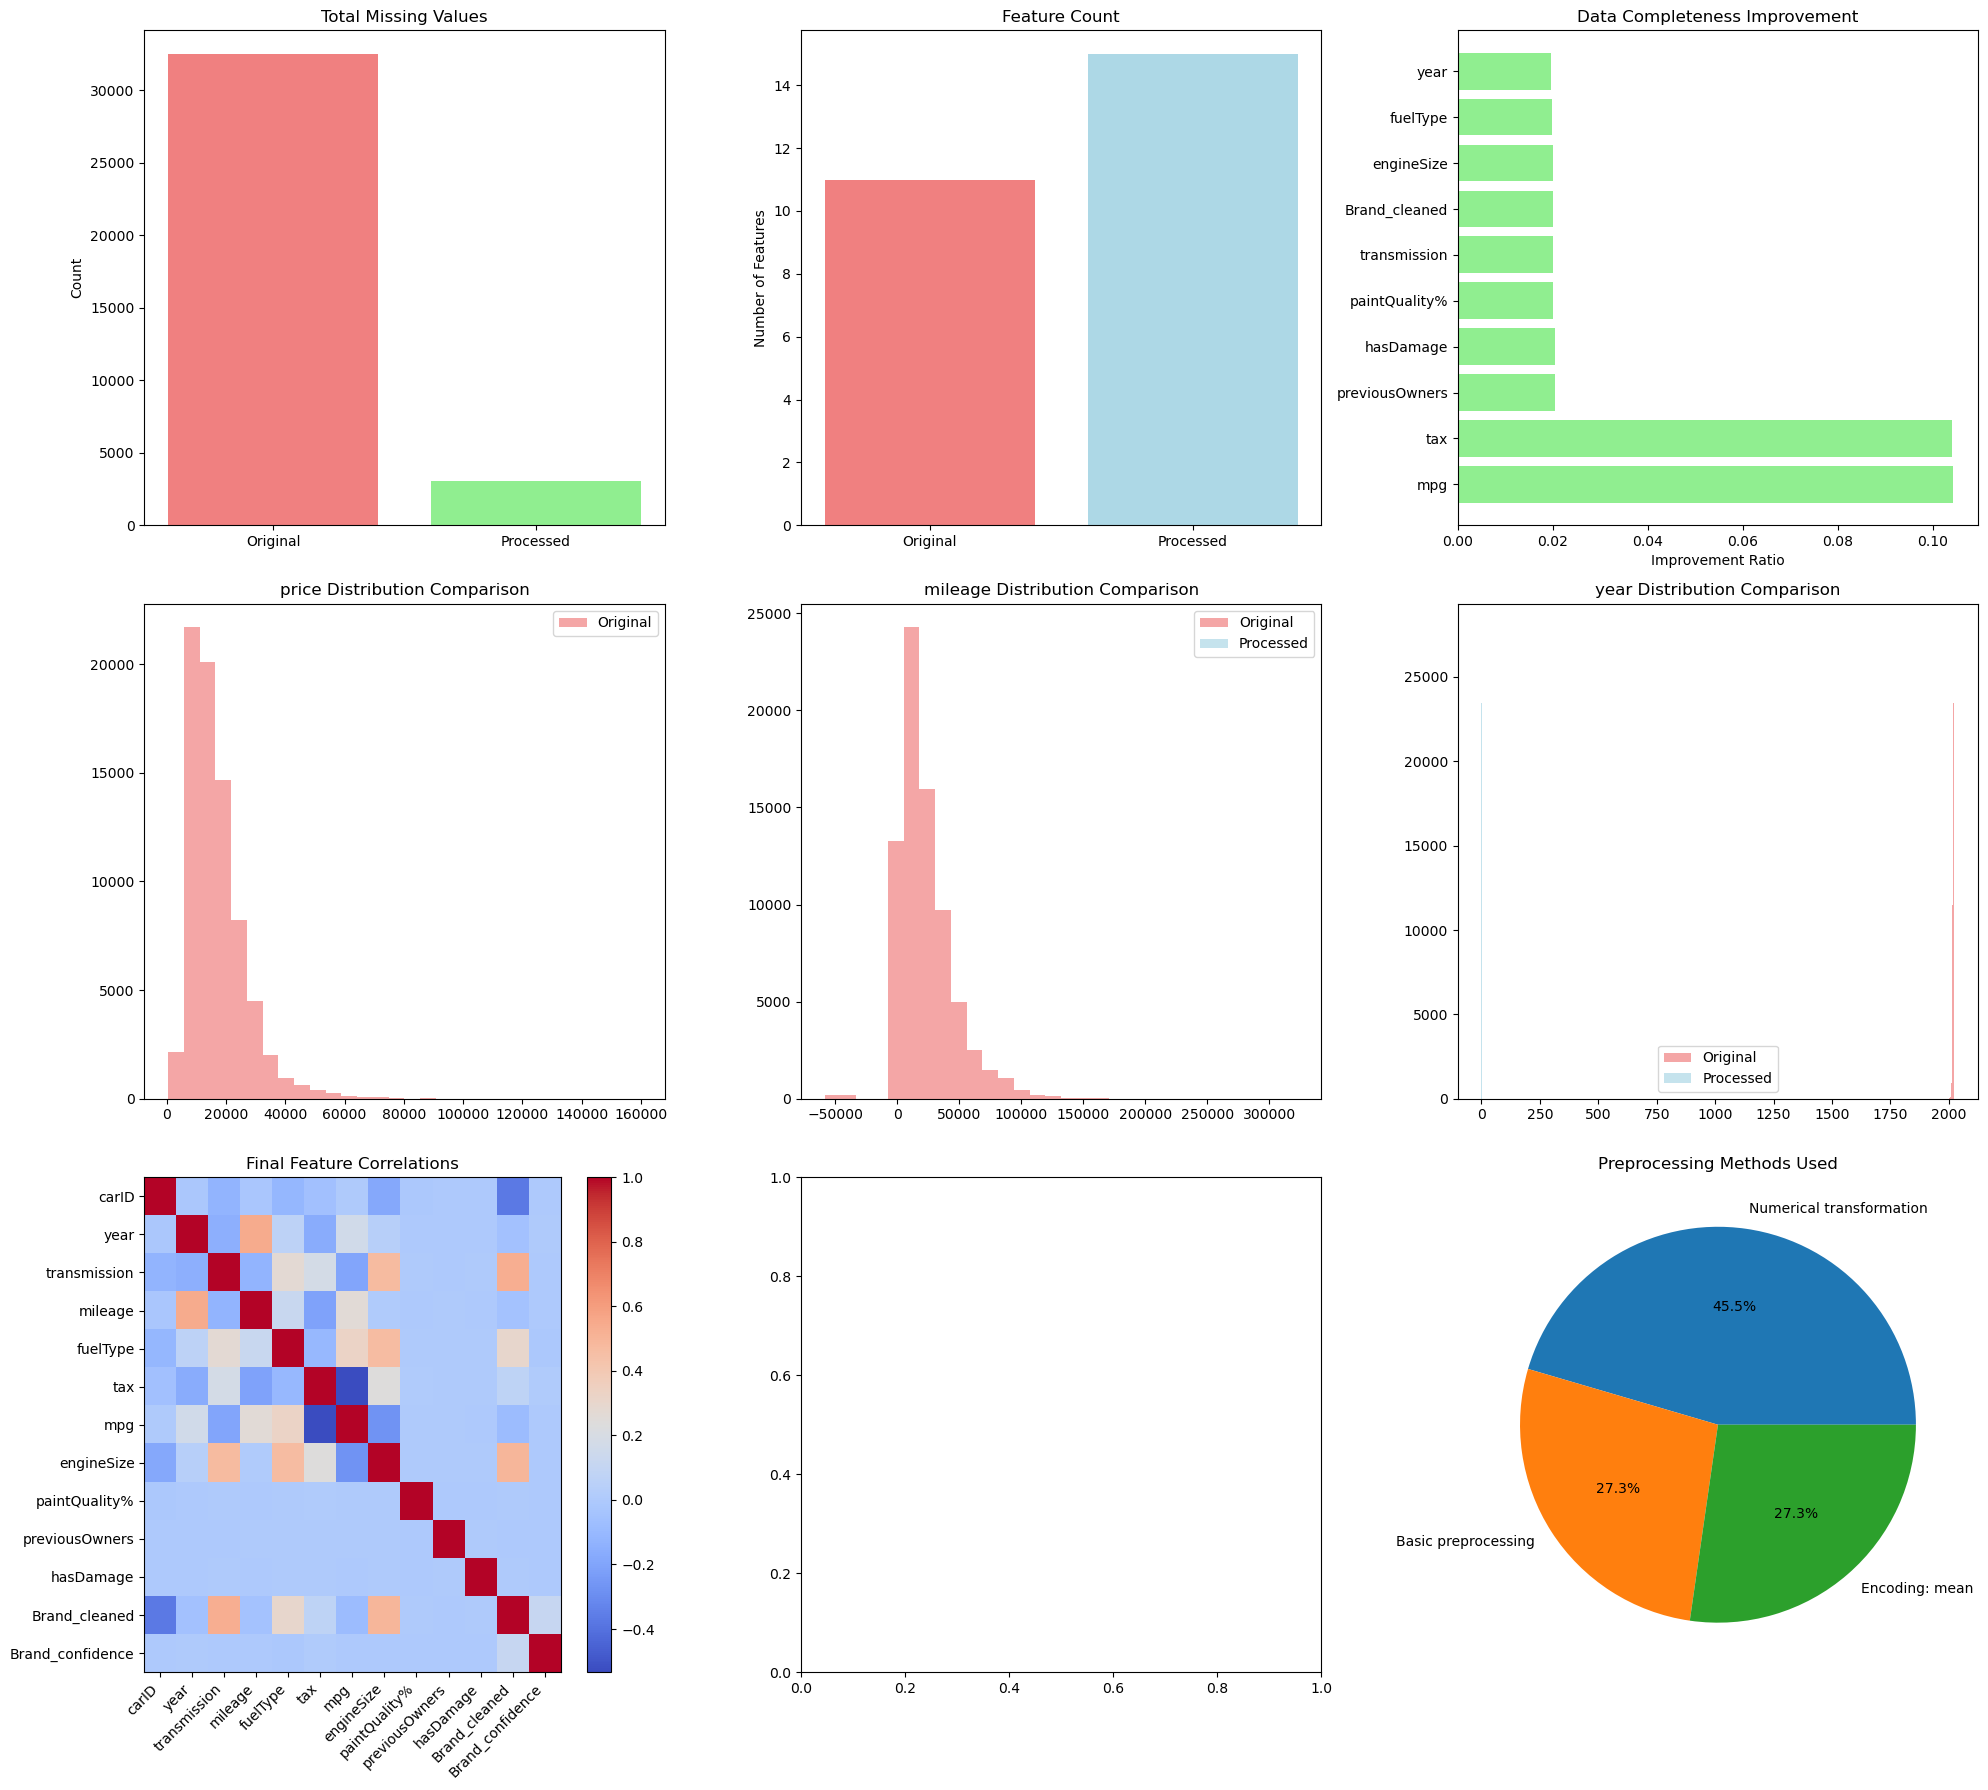


=== PROCESSING SUMMARY METRICS ===
original_features: 11
final_features: 15
expansion_ratio: 1.36
missing_values_eliminated: 29476
data_completeness: 99.73


In [5]:
print("STEP 3: OVERALL PROCESSING IMPACT ASSESSMENT")
print("=" * 60)

# Create overall processing dashboard
dashboard_results = create_processing_summary_dashboard(
    processed_df=X_train_processed, 
    original_df=train_data_step1, 
    feature_configs=feature_configs
)

print(f"\n=== PROCESSING SUMMARY METRICS ===")
for key, value in dashboard_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

STEP 4: DETAILED NUMERICAL FEATURES EXPLORATION

1. MILEAGE FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: MILEAGE
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,510
  Missing: 1,463
  Range: [-58540.574, 323000.000]
  Mean: 23004.184
  Std: 22129.788
  Skewness: 1.555

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [-5.804, 1.122]
  Mean: -0.000
  Std: 1.000
  Skewness: -2.357

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1463 → 0
  Outliers (IQR): 3617 → 3275
  Skewness improvement: -0.802


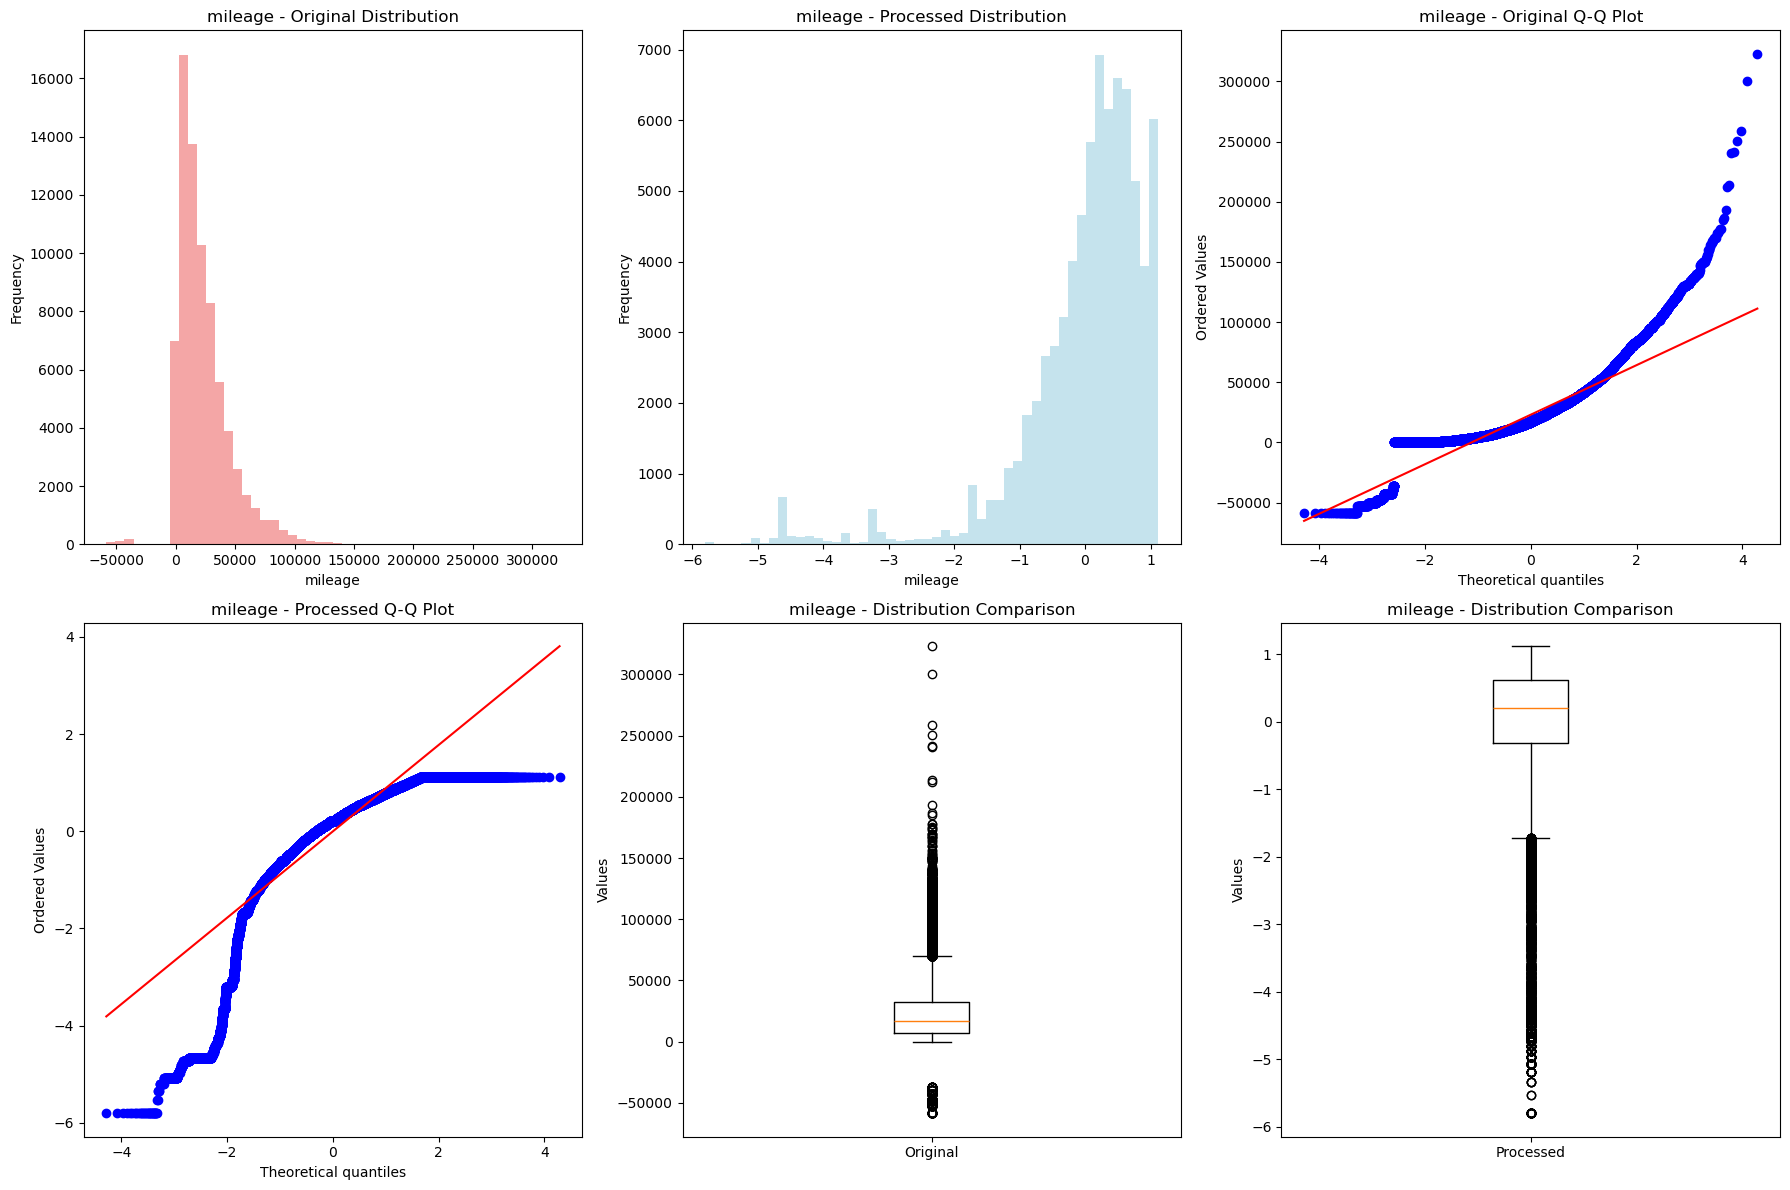


=== FEATURE ENGINEERING INSIGHTS ===
⚠️  Distribution still highly skewed - consider additional transformations
✓ No missing values after preprocessing

2. YEAR/AGE FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: YEAR
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,482
  Missing: 1,491
  Range: [1970.000, 2024.122]
  Mean: 2017.097
  Std: 2.209
  Skewness: -1.854

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [0.000, 1.000]
  Mean: 0.130
  Std: 0.040
  Skewness: 1.872

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1491 → 0
  Outliers (IQR): 1791 → 1791
  Skewness improvement: -0.018


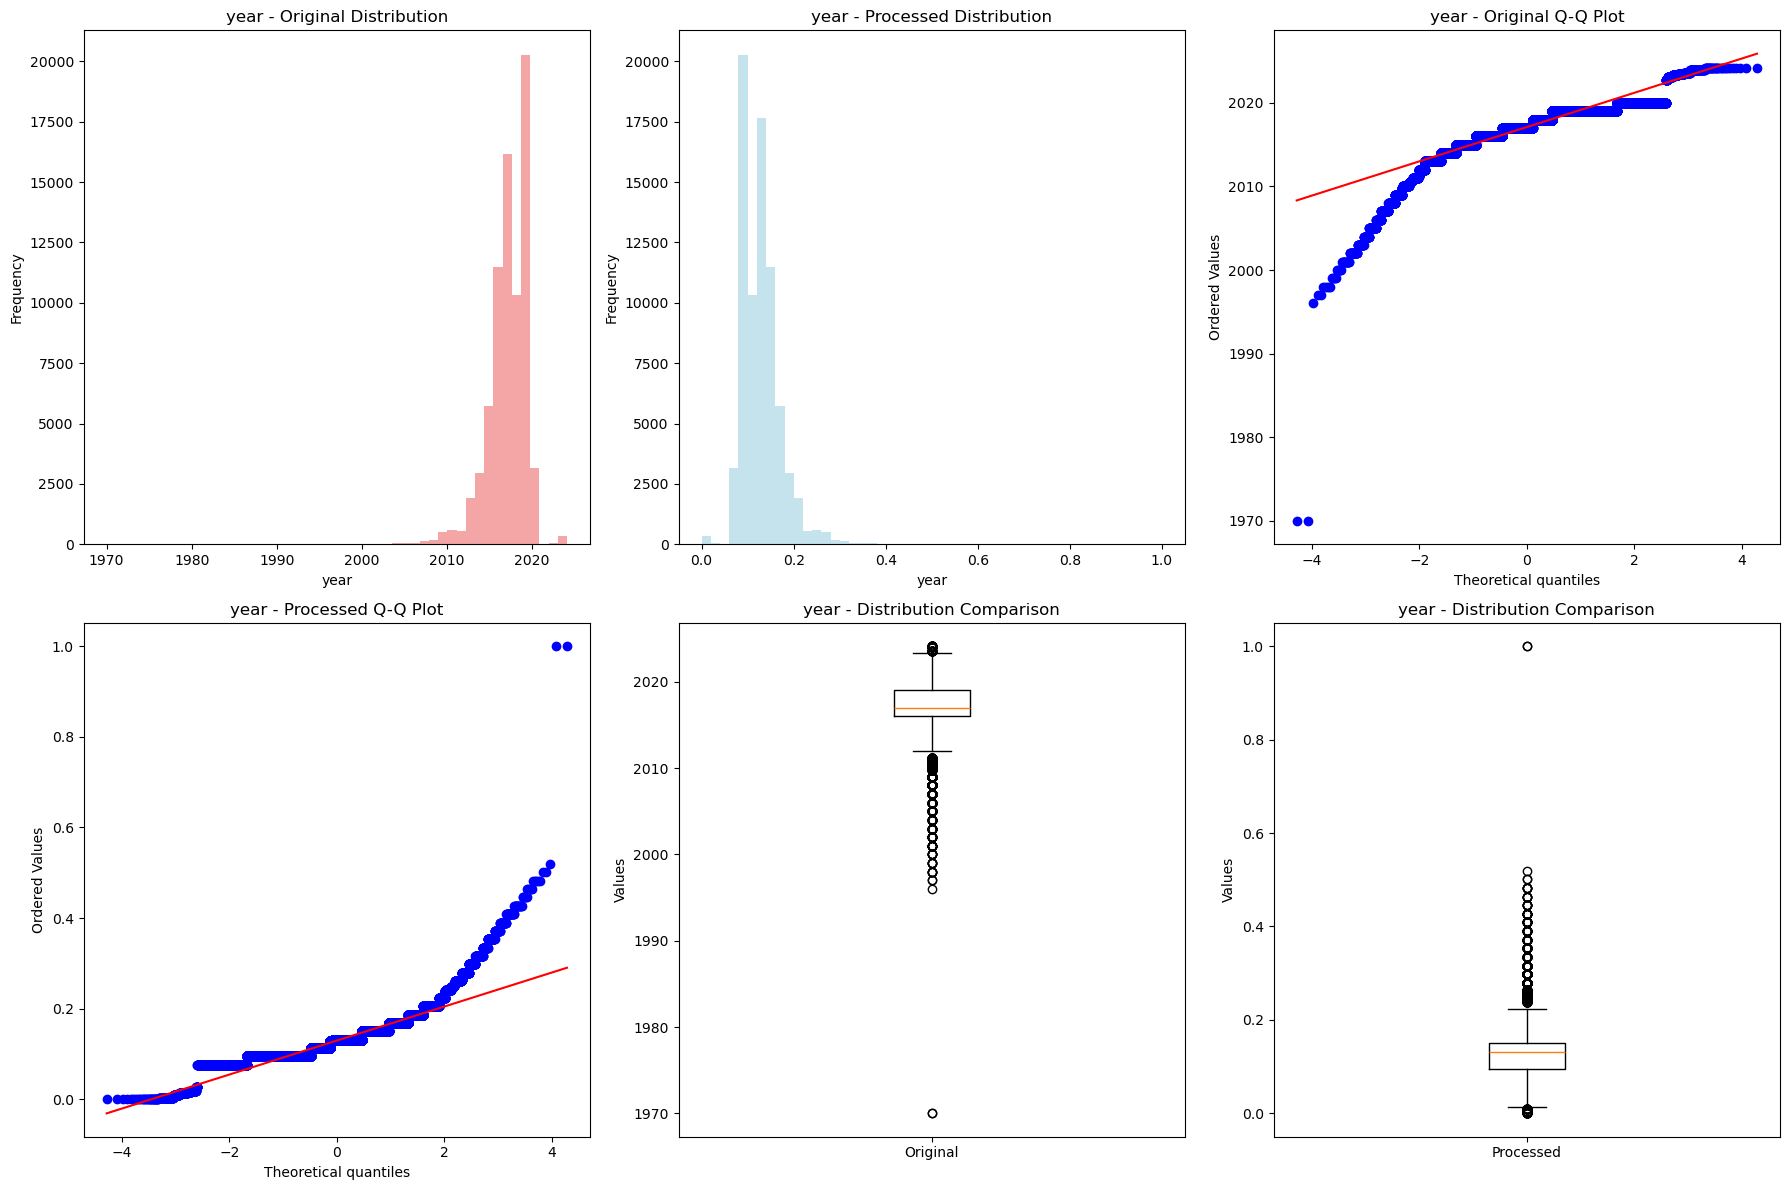


=== FEATURE ENGINEERING INSIGHTS ===
⚠️  Distribution still highly skewed - consider additional transformations
✓ No missing values after preprocessing

3. ENGINE SIZE FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: ENGINESIZE
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,457
  Missing: 1,516
  Range: [-0.103, 6.600]
  Mean: 1.660
  Std: 0.573
  Skewness: 1.233

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [-2.129, 6.250]
  Mean: 0.074
  Std: 0.710
  Skewness: 1.251

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1516 → 0
  Outliers (IQR): 716 → 716
  Skewness improvement: -0.018


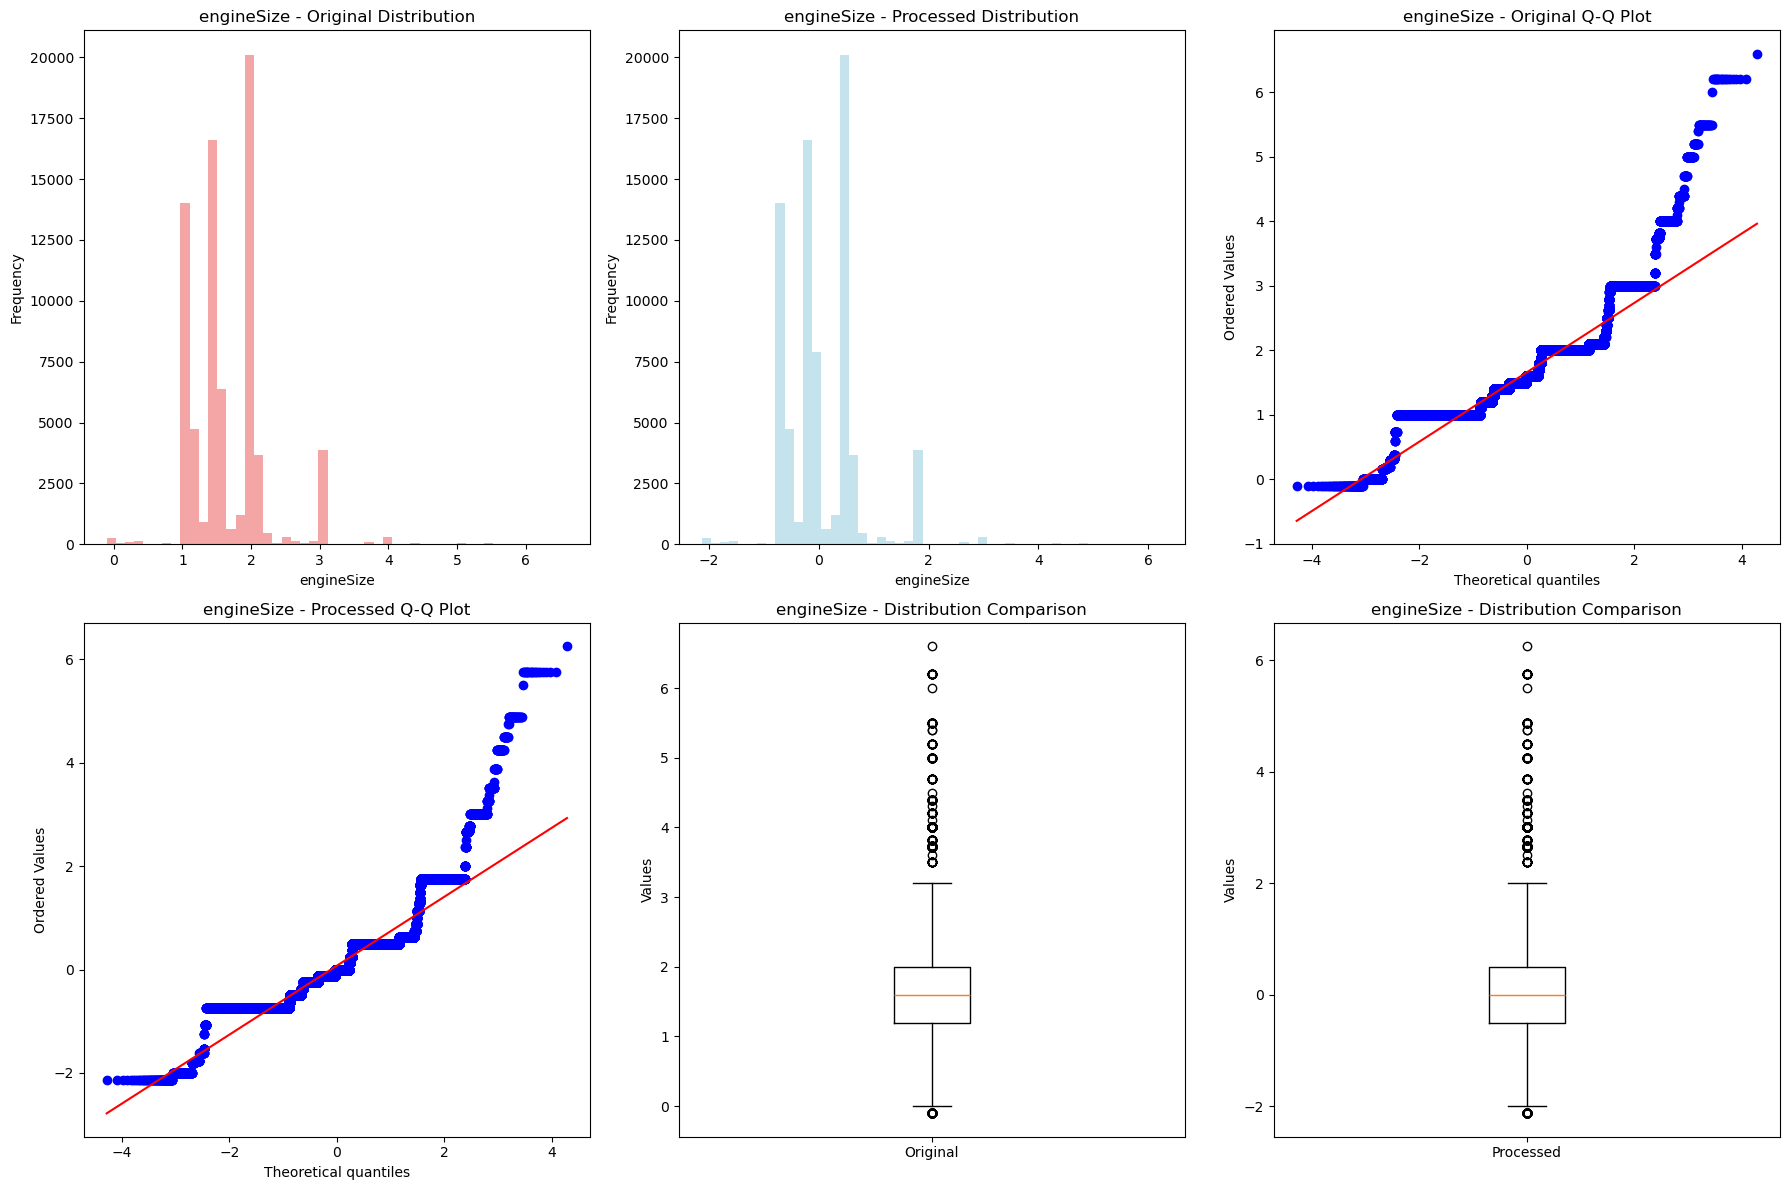


=== FEATURE ENGINEERING INSIGHTS ===
⚠️  Distribution still highly skewed - consider additional transformations
✓ No missing values after preprocessing

4. TAX FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: TAX
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 68,069
  Missing: 7,904
  Range: [-91.122, 580.000]
  Mean: 120.329
  Std: 65.521
  Skewness: 0.051

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [-3.426, 7.317]
  Mean: 0.000
  Std: 1.000
  Skewness: -0.064

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 7904 → 0
  Outliers (IQR): 20306 → 20306
  Skewness improvement: -0.012


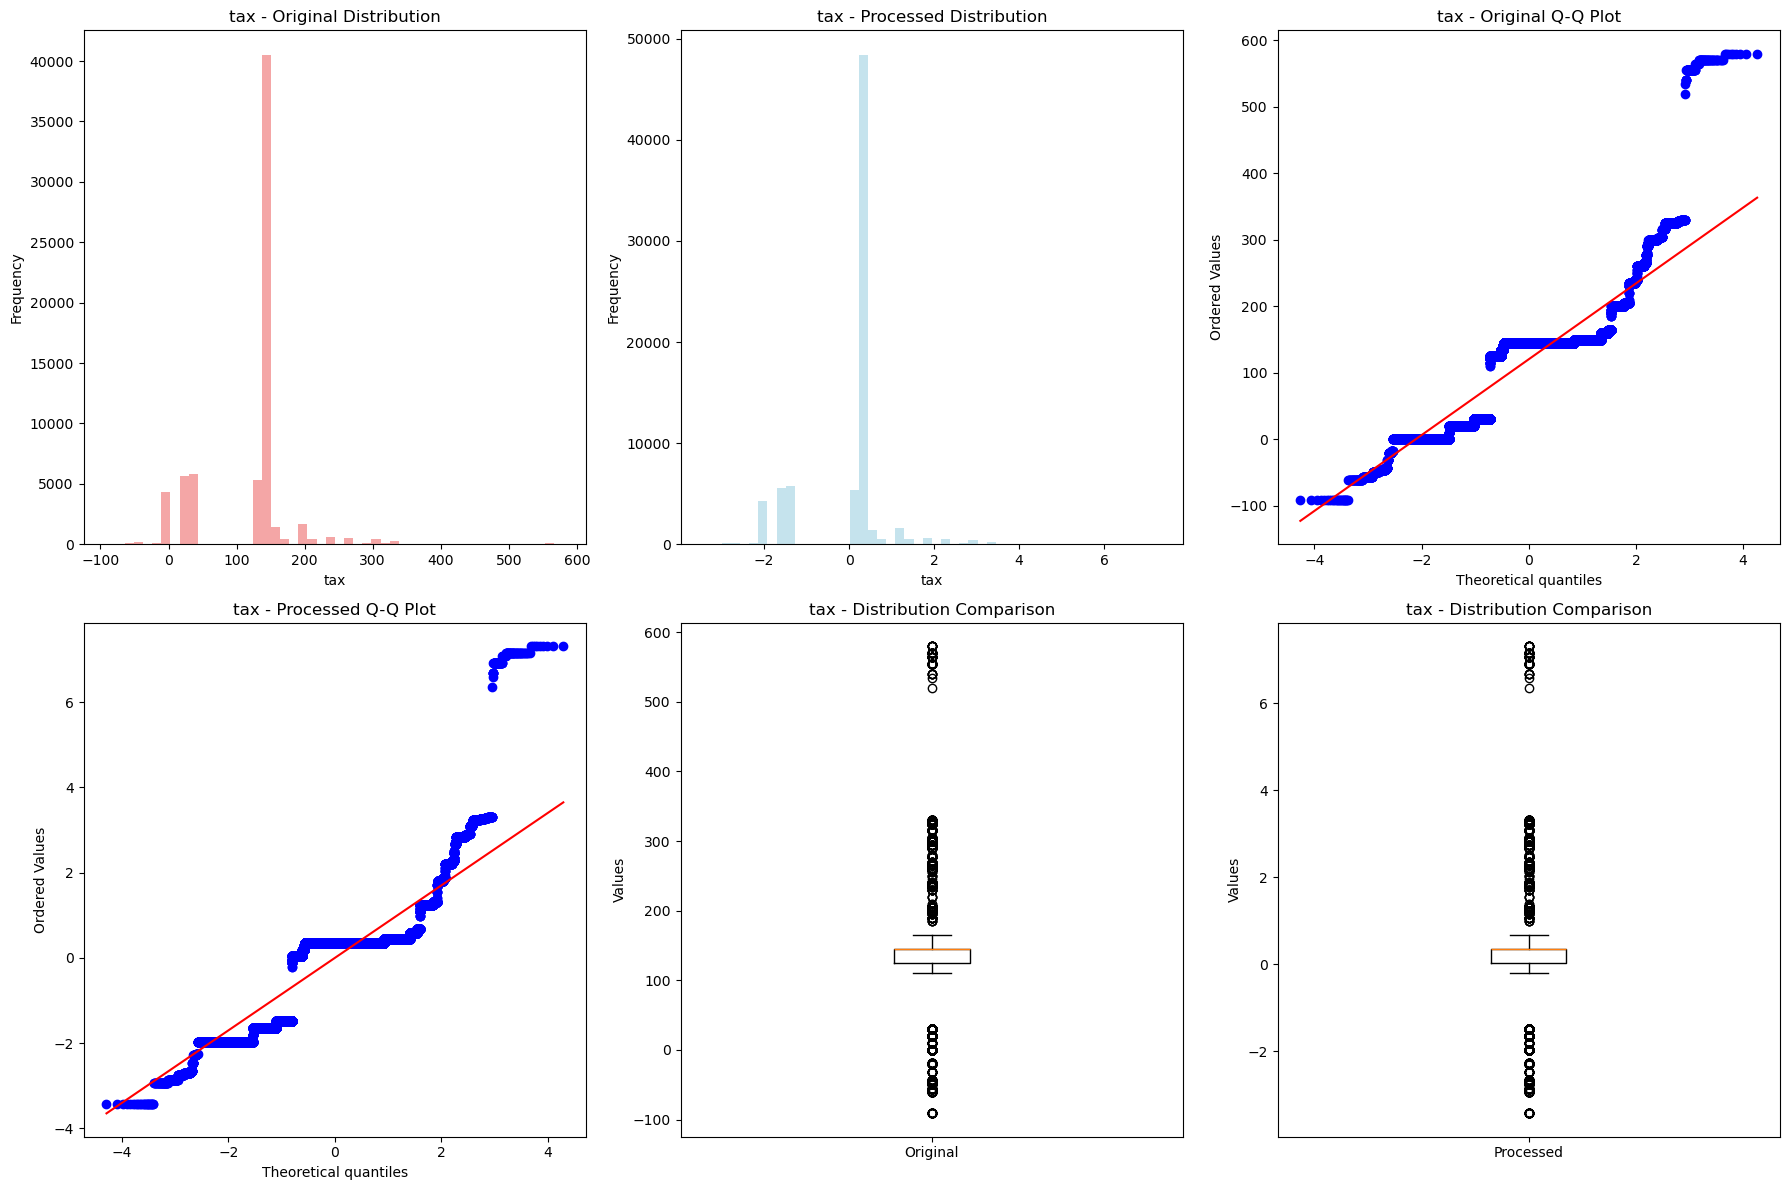


=== FEATURE ENGINEERING INSIGHTS ===
✓ Distribution is now approximately normal
✓ No missing values after preprocessing

5. MPG FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: MPG
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 68,047
  Missing: 7,926
  Range: [-43.422, 470.800]
  Mean: 55.153
  Std: 16.498
  Skewness: 7.297

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [-2.611, 2.552]
  Mean: -0.000
  Std: 1.000
  Skewness: 0.057

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 7926 → 0
  Outliers (IQR): 1200 → 0
  Skewness improvement: 7.240


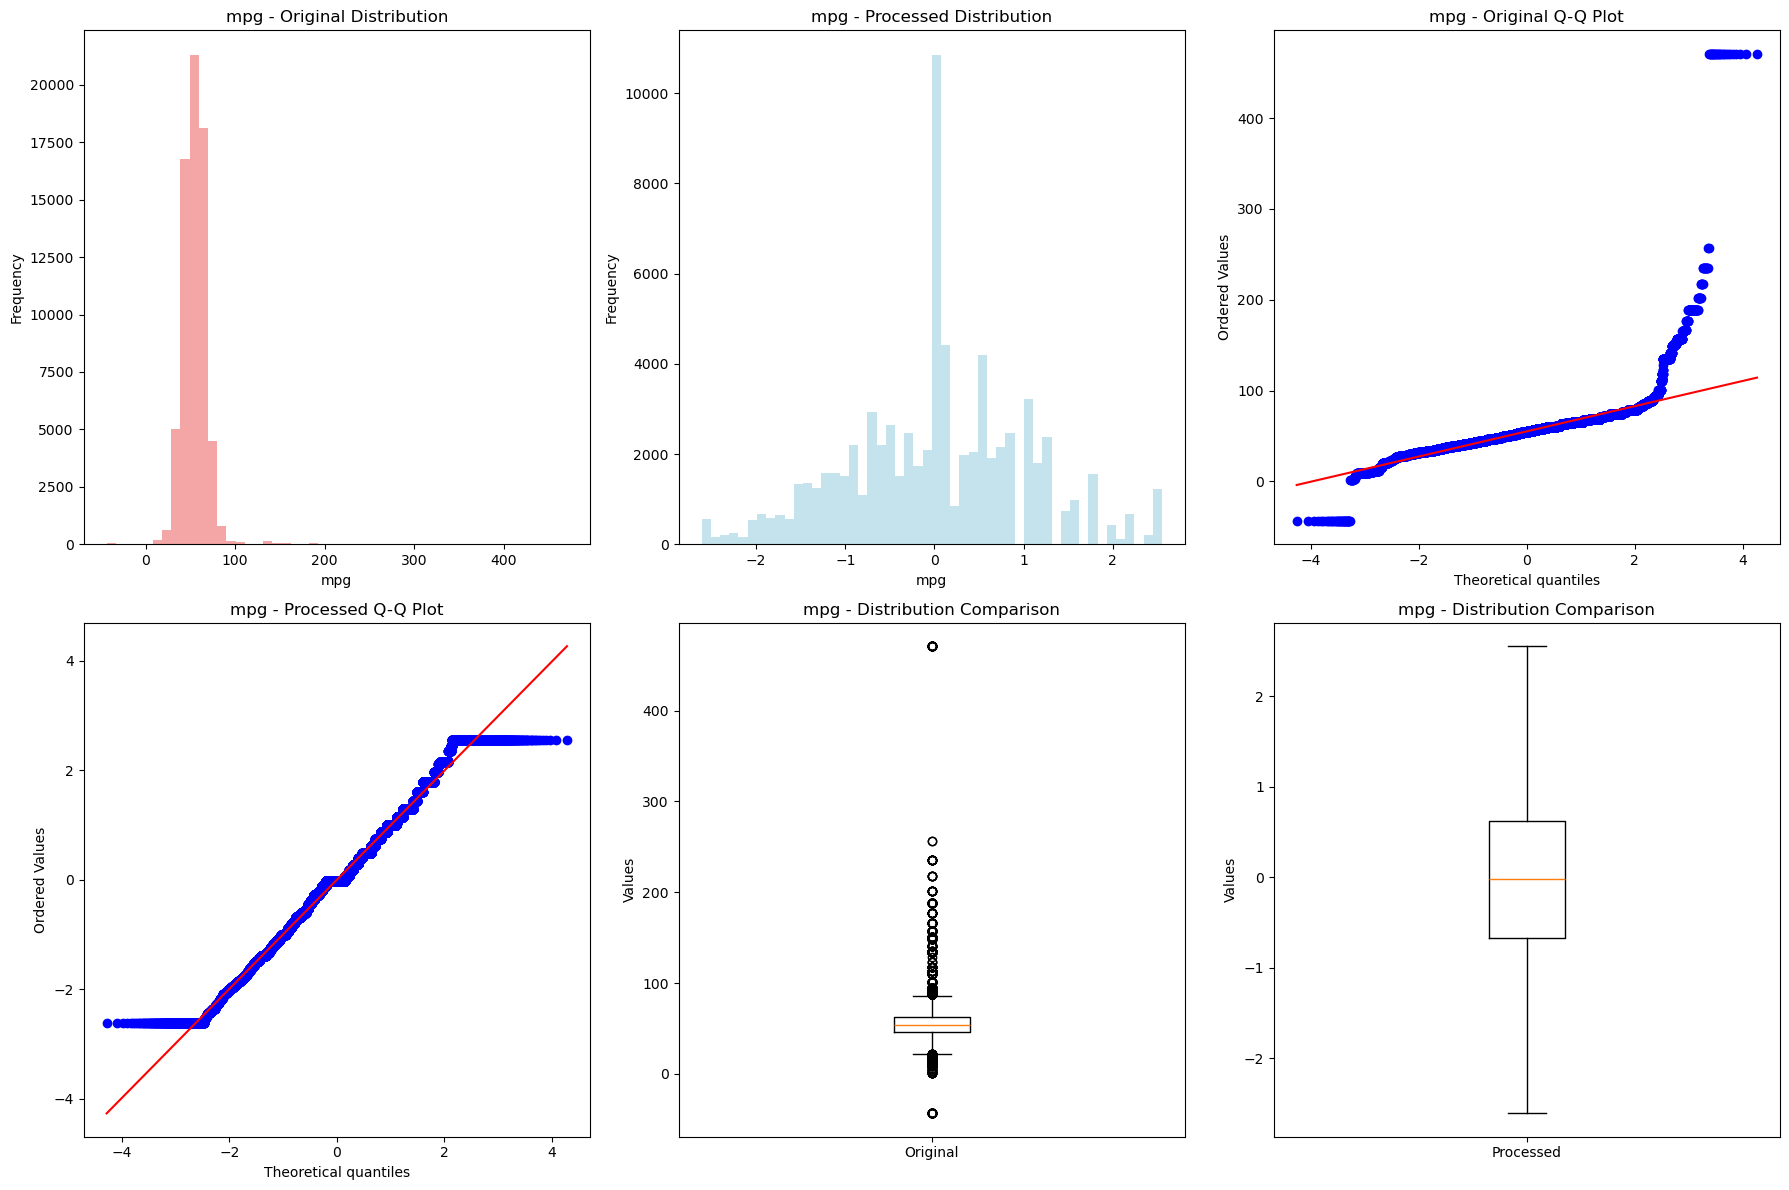


=== FEATURE ENGINEERING INSIGHTS ===
✓ Distribution is now approximately normal
✓ No missing values after preprocessing


In [6]:
print("STEP 4: DETAILED NUMERICAL FEATURES EXPLORATION")
print("=" * 60)

# Analyze each numerical feature in detail
numerical_features_analysis = {}

# 1. Mileage Analysis (log-transformed)
print("\n" + "="*80)
print("1. MILEAGE FEATURE ANALYSIS")
print("="*80)
mileage_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='mileage',
    target_col='price'
)
numerical_features_analysis['mileage'] = mileage_results

# 2. Year/Age Analysis (converted to car age)
print("\n" + "="*80)
print("2. YEAR/AGE FEATURE ANALYSIS")
print("="*80)
year_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='year',
    target_col='price'
)
numerical_features_analysis['year'] = year_results

# 3. Engine Size Analysis (normalized)
print("\n" + "="*80)
print("3. ENGINE SIZE FEATURE ANALYSIS")
print("="*80)
engine_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='engineSize',
    target_col='price'
)
numerical_features_analysis['engineSize'] = engine_results

# 4. Tax Analysis
print("\n" + "="*80)
print("4. TAX FEATURE ANALYSIS")
print("="*80)
tax_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='tax',
    target_col='price'
)
numerical_features_analysis['tax'] = tax_results

# 5. MPG Analysis
print("\n" + "="*80)
print("5. MPG FEATURE ANALYSIS")
print("="*80)
mpg_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='mpg',
    target_col='price'
)
numerical_features_analysis['mpg'] = mpg_results


6. PAINT QUALITY FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: PAINTQUALITY%
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,449
  Missing: 1,524
  Range: [1.639, 125.594]
  Mean: 64.591
  Std: 21.021
  Skewness: -0.011

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [0.000, 1.000]
  Mean: 0.639
  Std: 0.209
  Skewness: -0.095

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1524 → 0
  Outliers (IQR): 0 → 0
  Skewness improvement: -0.084


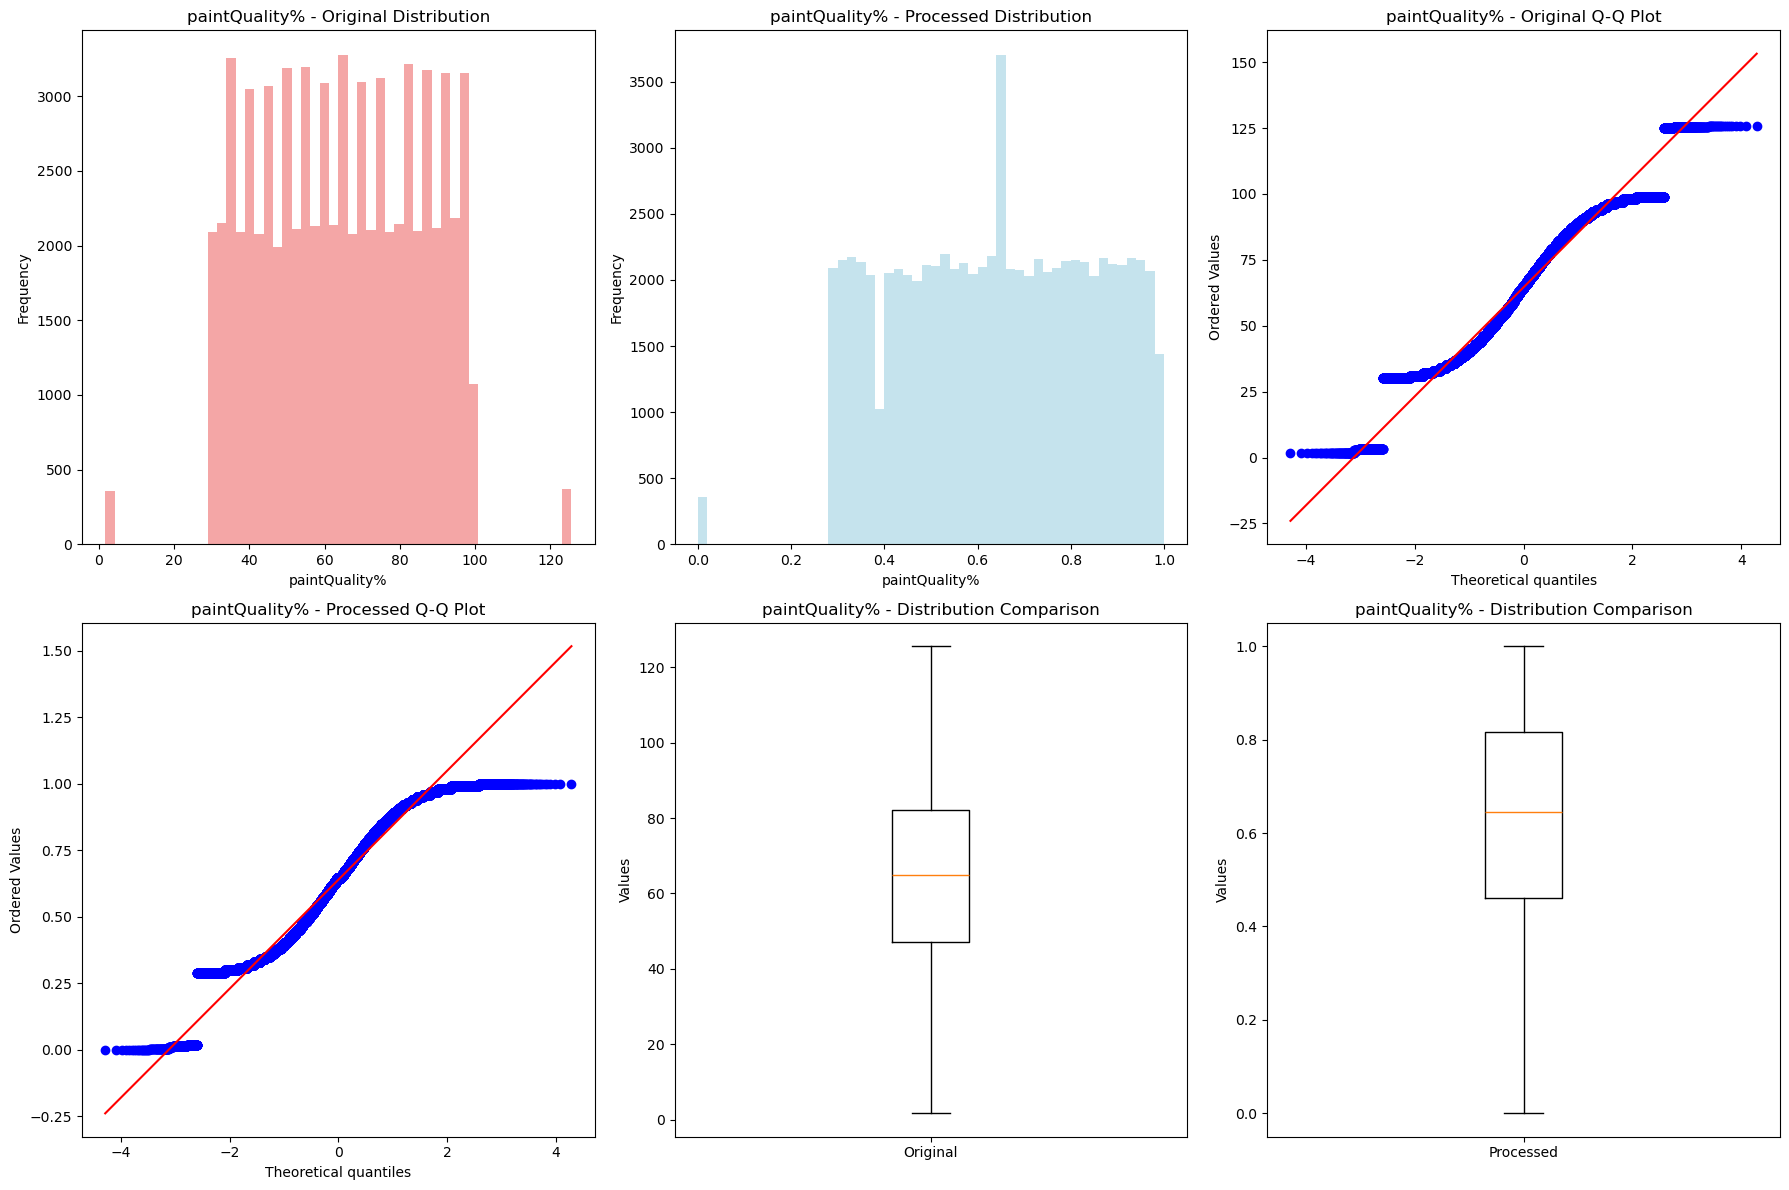


=== FEATURE ENGINEERING INSIGHTS ===
✓ Distribution is now approximately normal
✓ No missing values after preprocessing

7. PREVIOUS OWNERS FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: PREVIOUSOWNERS
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,423
  Missing: 1,550
  Range: [-2.346, 6.258]
  Mean: 1.995
  Std: 1.473
  Skewness: -0.003

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [-1.703, 1.732]
  Mean: 0.000
  Std: 1.000
  Skewness: -0.594

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1550 → 0
  Outliers (IQR): 734 → 0
  Skewness improvement: -0.591


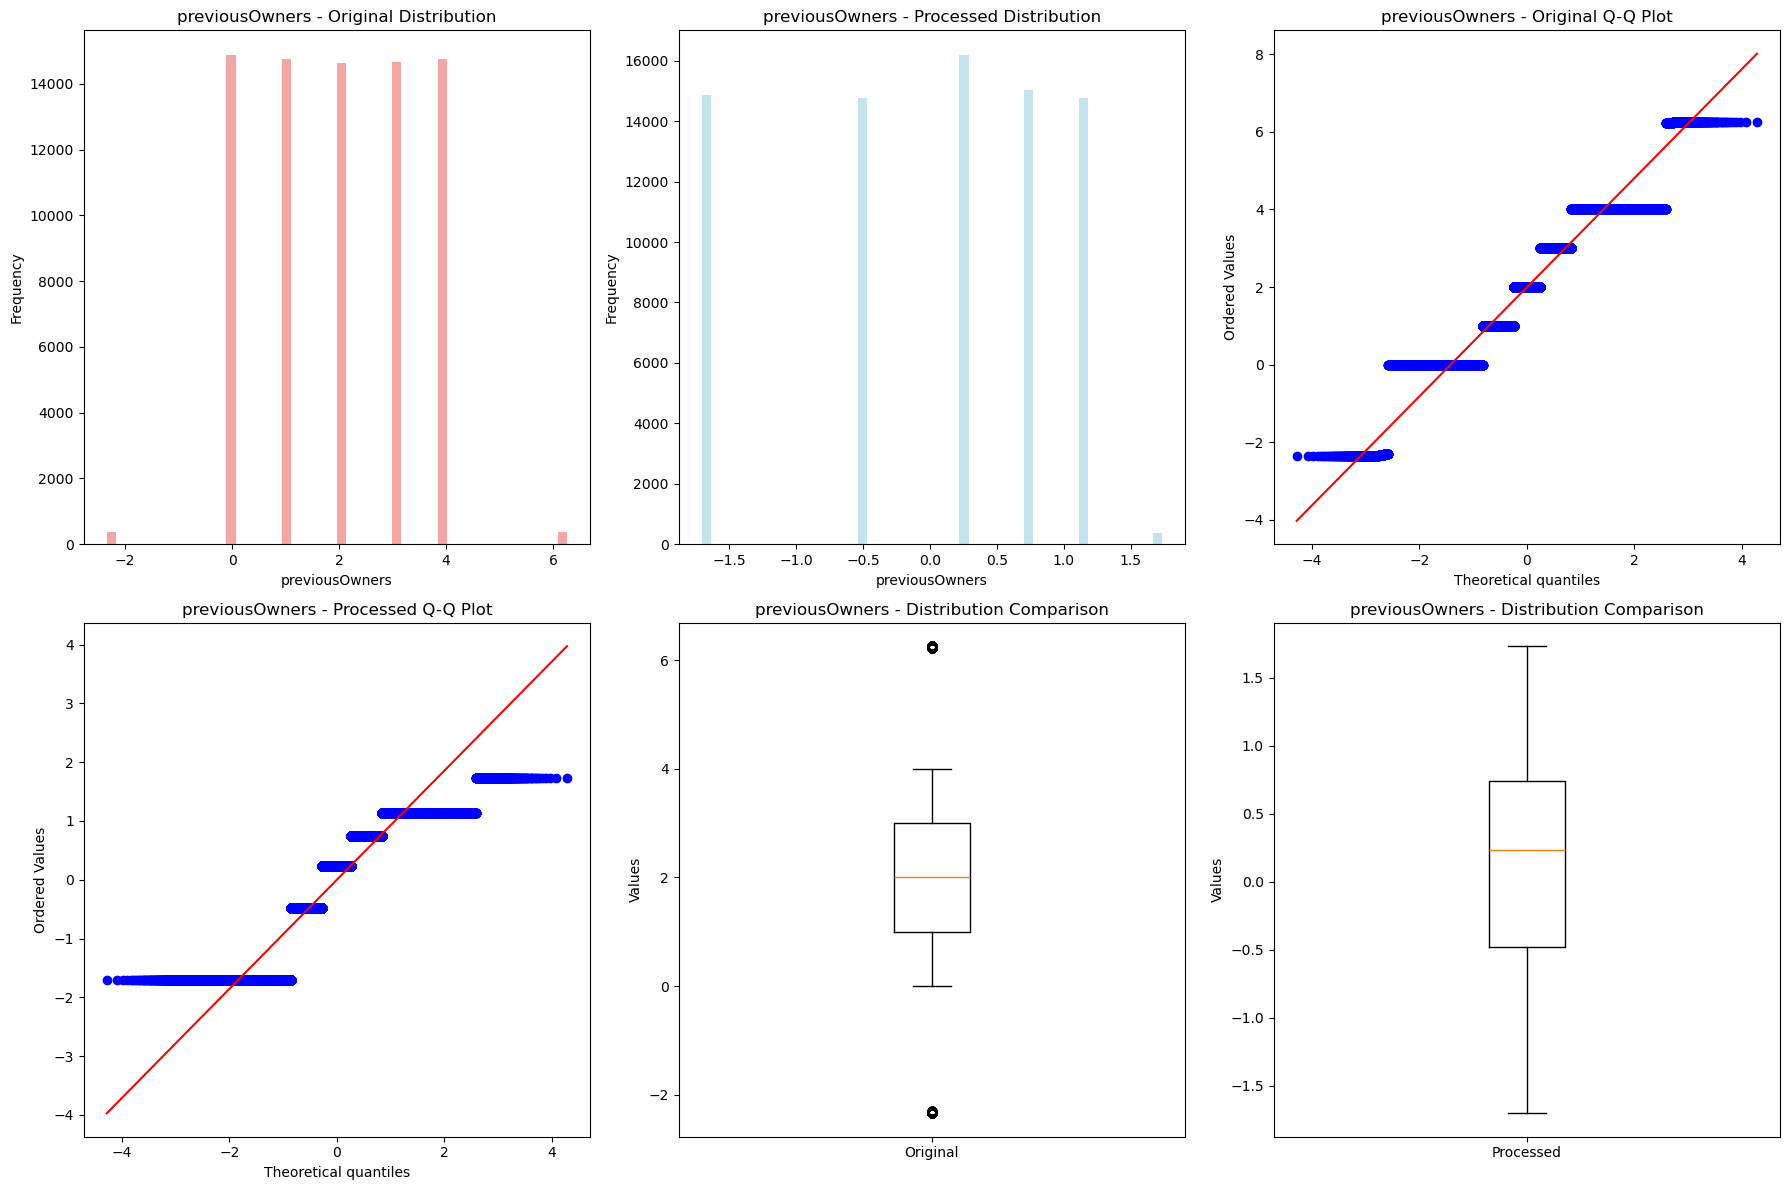


=== FEATURE ENGINEERING INSIGHTS ===
✓ Distribution is moderately skewed (acceptable)
✓ No missing values after preprocessing

8. DAMAGE INDICATOR FEATURE ANALYSIS

PROCESSED NUMERICAL ANALYSIS: HASDAMAGE
=== PROCESSING IMPACT COMPARISON ===
ORIGINAL DATA:
  Count: 74,425
  Missing: 1,548
  Range: [0.000, 0.000]
  Mean: 0.000
  Std: 0.000
  Skewness: 0.000

PROCESSED DATA:
  Count: 75,973
  Missing: 0
  Range: [0.000, 1.000]
  Mean: 0.020
  Std: 0.141
  Skewness: 6.790

=== DATA QUALITY IMPROVEMENTS ===
  Missing values: 1548 → 0
  Outliers (IQR): 0 → 1548
  Skewness improvement: -6.790


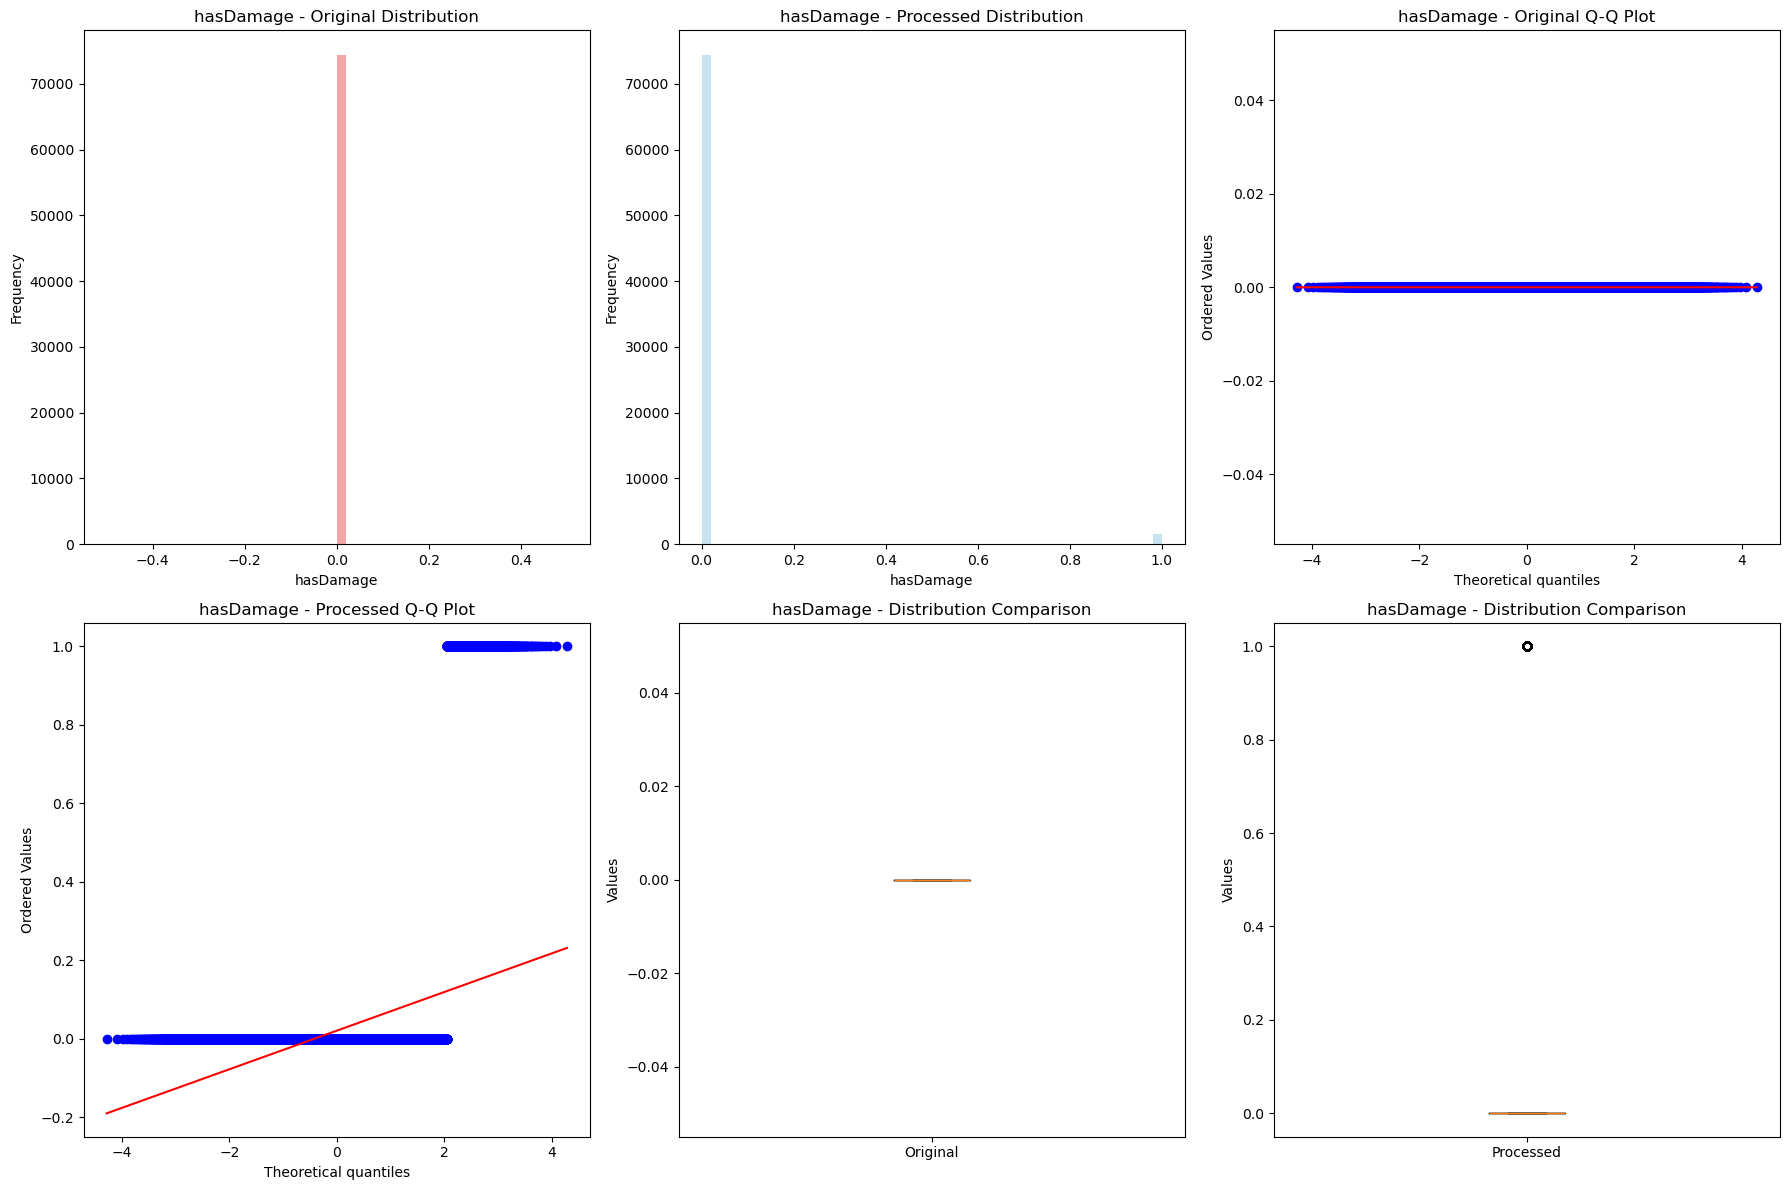


=== FEATURE ENGINEERING INSIGHTS ===
⚠️  Distribution still highly skewed - consider additional transformations
✓ No missing values after preprocessing

NUMERICAL FEATURES PROCESSING SUMMARY

Correlation with target (price) ranking:

Skewness improvement summary:
mileage        : -2.357 ⚠ Still skewed
year           :  1.872 ⚠ Still skewed
engineSize     :  1.251 ⚠ Still skewed
tax            : -0.064 ✓ Good
mpg            :  0.057 ✓ Good
paintQuality%  : -0.095 ✓ Good
previousOwners : -0.594 ✓ Good
hasDamage      :  6.790 ⚠ Still skewed


In [7]:
# 6. Paint Quality Analysis (normalized to 0-1)
print("\n" + "="*80)
print("6. PAINT QUALITY FEATURE ANALYSIS")
print("="*80)
paint_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='paintQuality%',
    target_col='price'
)
numerical_features_analysis['paintQuality%'] = paint_results

# 7. Previous Owners Analysis (log-transformed)
print("\n" + "="*80)
print("7. PREVIOUS OWNERS FEATURE ANALYSIS")
print("="*80)
owners_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='previousOwners',
    target_col='price'
)
numerical_features_analysis['previousOwners'] = owners_results

# 8. Damage Indicator Analysis
print("\n" + "="*80)
print("8. DAMAGE INDICATOR FEATURE ANALYSIS")
print("="*80)
damage_results = analyze_processed_numerical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='hasDamage',
    target_col='price'
)
numerical_features_analysis['hasDamage'] = damage_results

# Numerical features summary
print(f"\n{'='*60}")
print("NUMERICAL FEATURES PROCESSING SUMMARY")
print(f"{'='*60}")

print("\nCorrelation with target (price) ranking:")
correlations = [(feature, results['correlation_with_target']) 
               for feature, results in numerical_features_analysis.items() 
               if results and results['correlation_with_target'] is not None]

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for i, (feature, corr) in enumerate(correlations, 1):
    print(f"{i:2d}. {feature:15s}: {corr:6.3f}")

print("\nSkewness improvement summary:")
for feature, results in numerical_features_analysis.items():
    if results and 'processed_stats' in results:
        skewness = results['processed_stats']['skewness']
        status = "✓ Good" if abs(skewness) < 1.0 else "⚠ Still skewed"
        print(f"{feature:15s}: {skewness:6.3f} {status}")

STEP 5: DETAILED CATEGORICAL FEATURES EXPLORATION

1. BRAND FEATURE ANALYSIS

PROCESSED CATEGORICAL ANALYSIS: BRAND_CLEANED
=== ORIGINAL DATA SUMMARY ===
  Total records: 75,973
  Unique values: 12
  Missing values: 1,521 (2.00%)
  Most common: 'ford' (16,056 occurrences)

=== PROCESSED DATA SUMMARY ===
  Encoding method: Target/Mean encoding
  Missing values: 0
  Value range: [10366.372, 24472.962]
  Mean: 16881.890
  Std: 5152.631

=== PROCESSING IMPROVEMENTS ===
✓ Converted to numerical encoding
✓ Preserved relationship with target variable


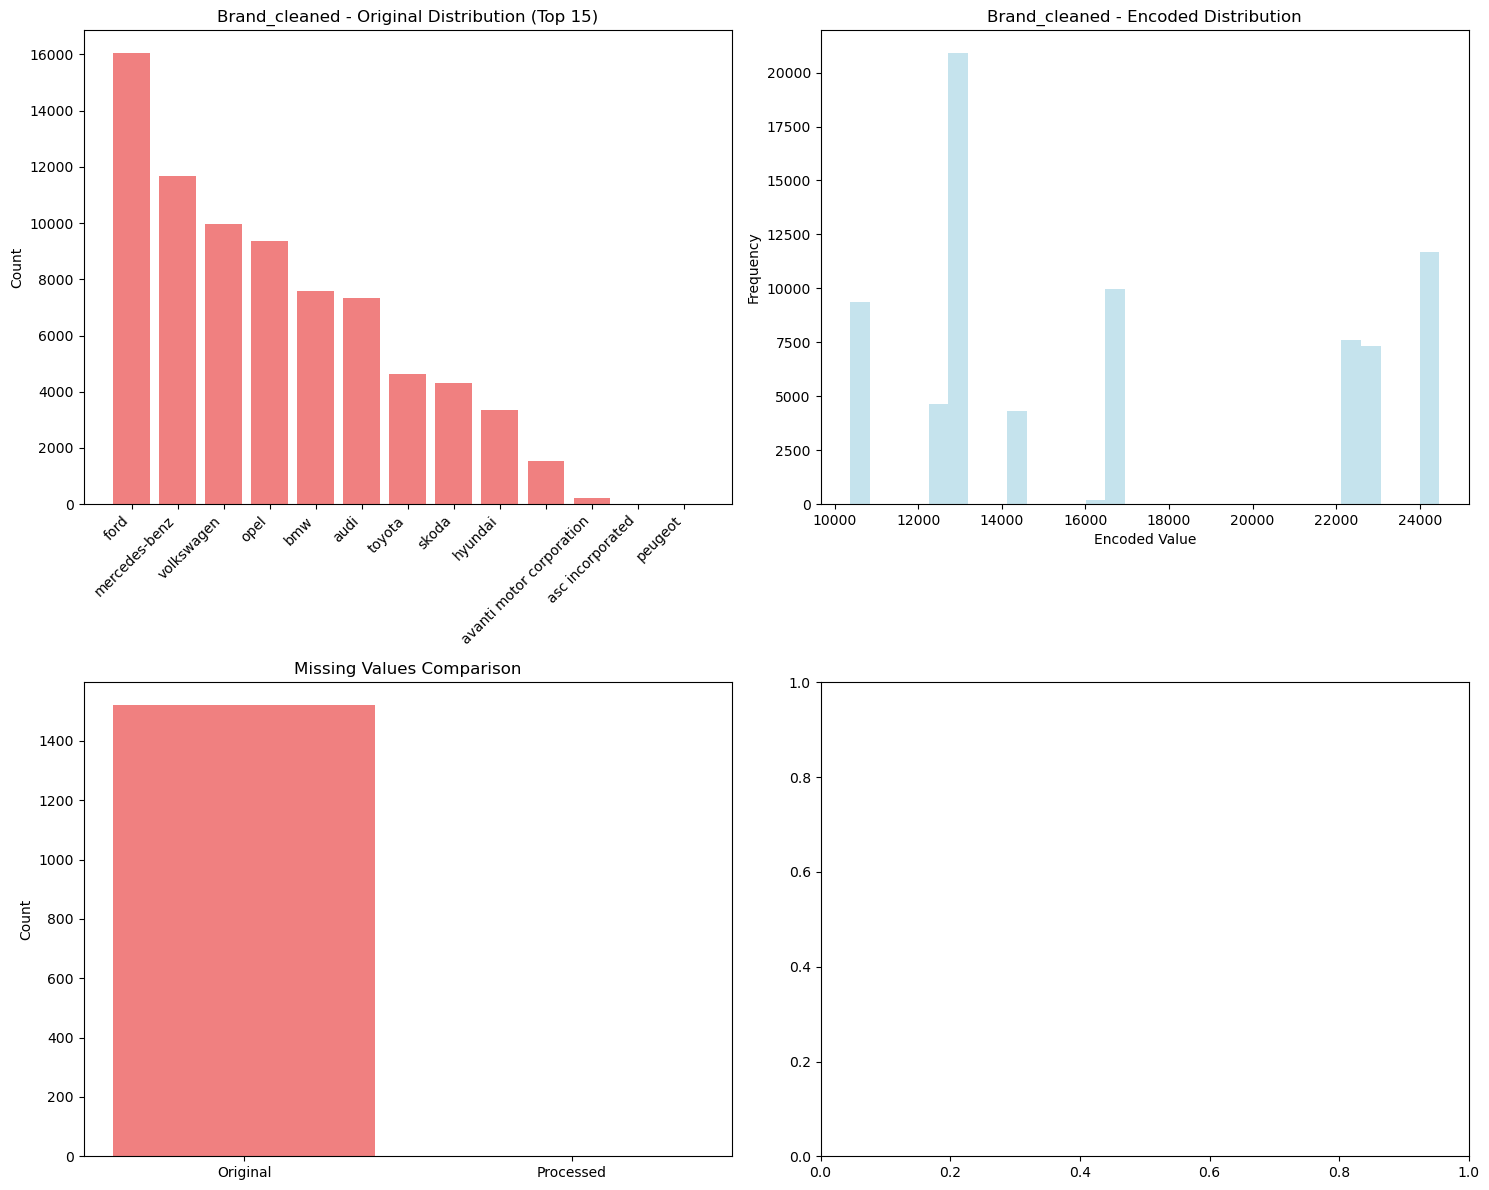


2. TRANSMISSION FEATURE ANALYSIS

PROCESSED CATEGORICAL ANALYSIS: TRANSMISSION
=== ORIGINAL DATA SUMMARY ===
  Total records: 75,973
  Unique values: 40
  Missing values: 1,522 (2.00%)
  Most common: 'Manual' (38,050 occurrences)

=== PROCESSED DATA SUMMARY ===
  Encoding method: Target/Mean encoding
  Missing values: 0
  Value range: [8495.000, 37253.714]
  Mean: 16881.890
  Std: 5306.072

=== PROCESSING IMPROVEMENTS ===
✓ Converted to numerical encoding
✓ Preserved relationship with target variable


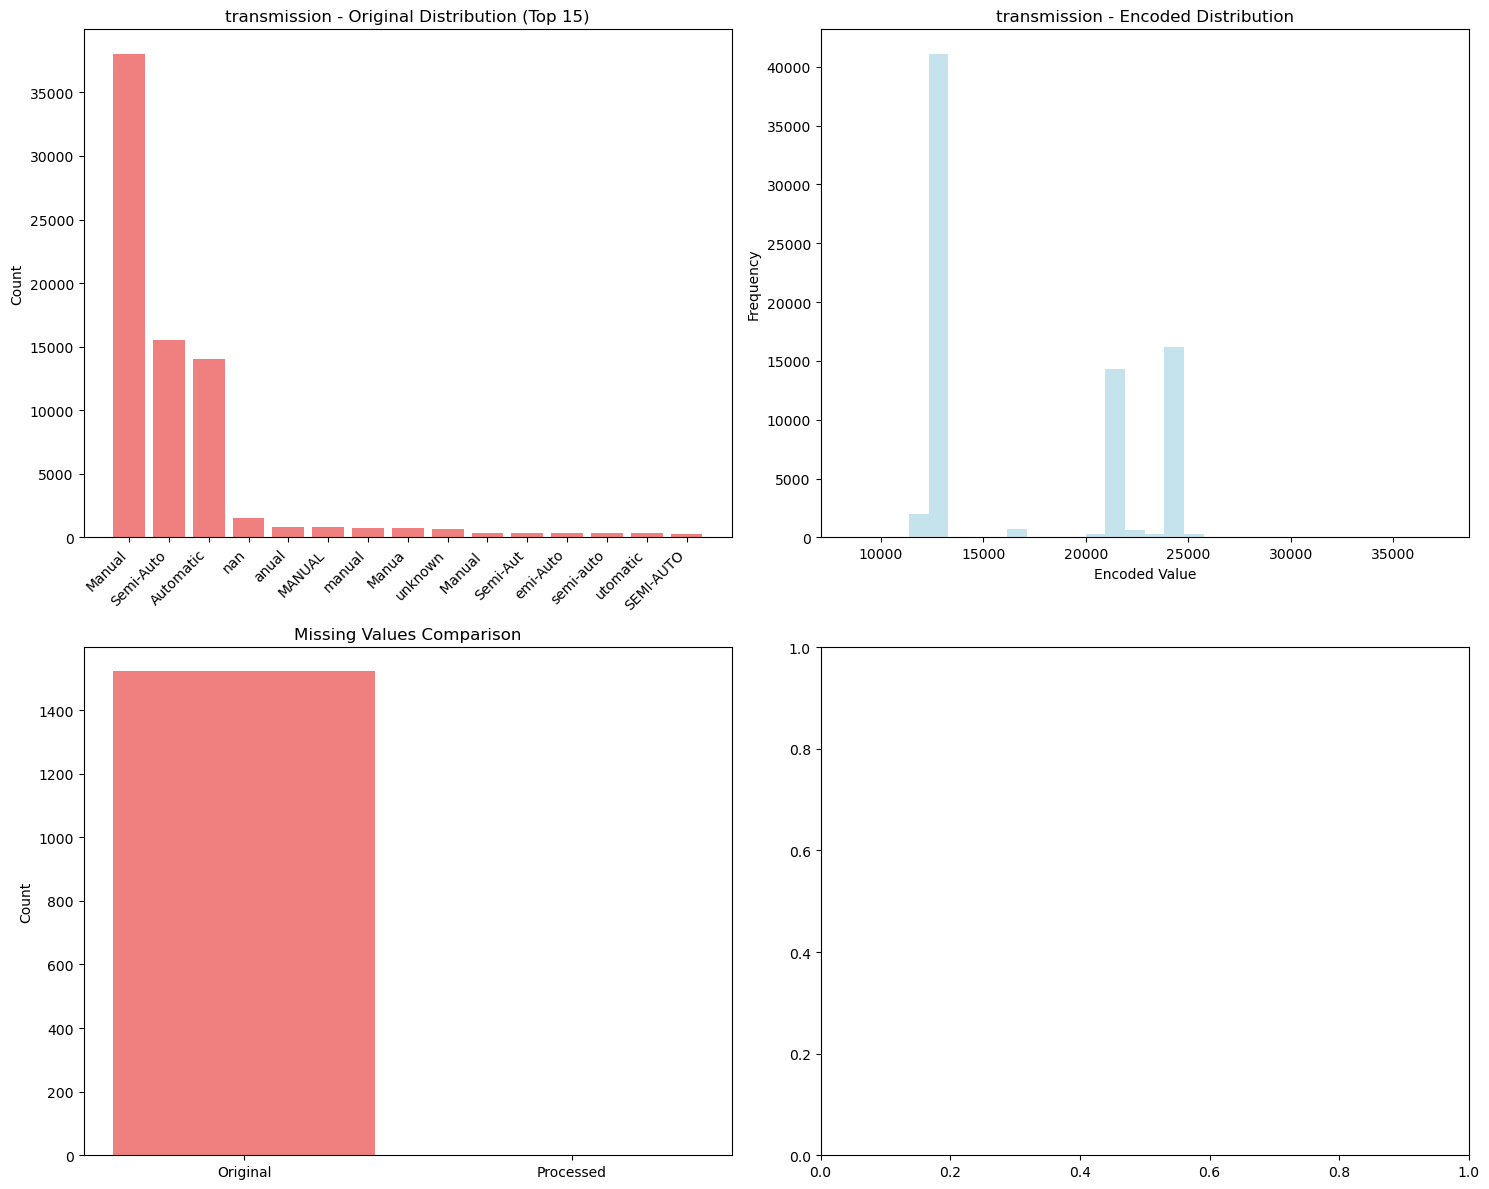


3. FUEL TYPE FEATURE ANALYSIS

PROCESSED CATEGORICAL ANALYSIS: FUELTYPE
=== ORIGINAL DATA SUMMARY ===
  Total records: 75,973
  Unique values: 34
  Missing values: 1,511 (1.99%)
  Most common: 'Petrol' (37,995 occurrences)

=== PROCESSED DATA SUMMARY ===
  Encoding method: Target/Mean encoding
  Missing values: 0
  Value range: [11200.000, 25338.750]
  Mean: 16881.890
  Std: 2035.727

=== PROCESSING IMPROVEMENTS ===
✓ Converted to numerical encoding
✓ Preserved relationship with target variable


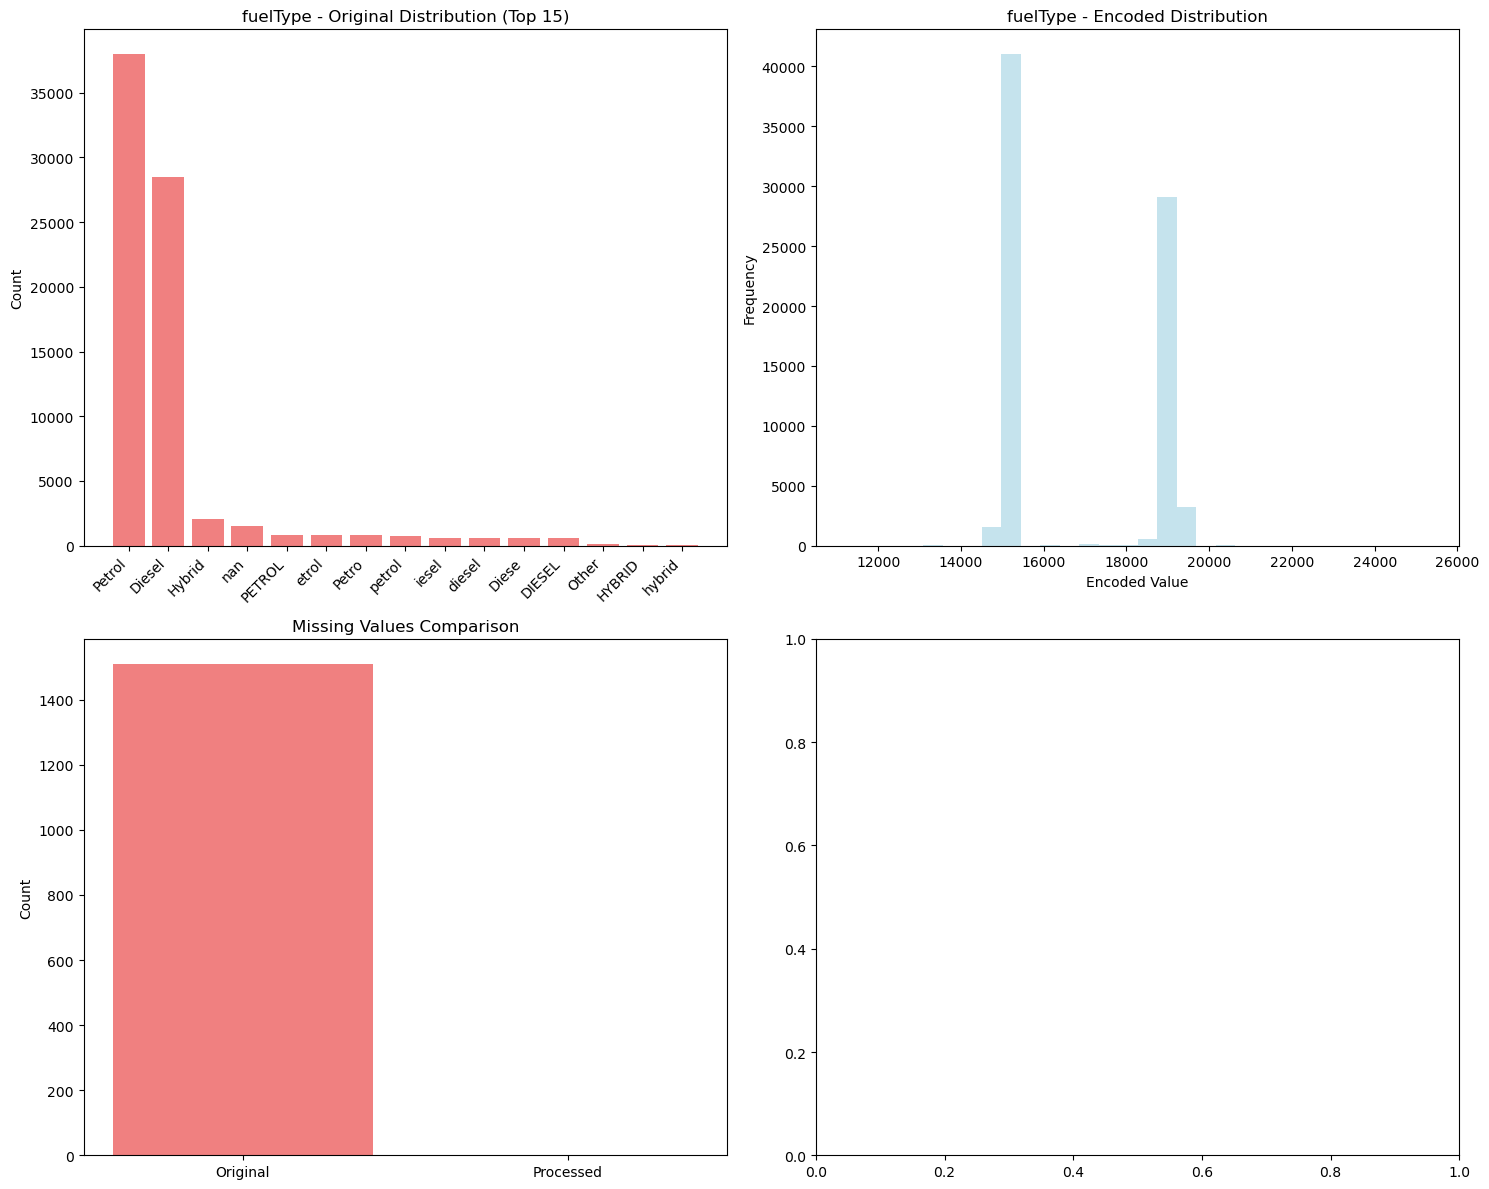


CATEGORICAL FEATURES PROCESSING SUMMARY

BRAND_CLEANED:
  Encoding type: target
  Original cardinality: 12
  Processed features: 1
  Missing values handled: ✓

TRANSMISSION:
  Encoding type: target
  Original cardinality: 40
  Processed features: 1
  Missing values handled: ✓

FUELTYPE:
  Encoding type: target
  Original cardinality: 34
  Processed features: 1
  Missing values handled: ✓


In [8]:
print("STEP 5: DETAILED CATEGORICAL FEATURES EXPLORATION")
print("=" * 60)

# Analyze each categorical feature in detail
categorical_features_analysis = {}

# 1. Brand Analysis (cleaned and encoded)
print("\n" + "="*80)
print("1. BRAND FEATURE ANALYSIS")
print("="*80)
brand_results = analyze_processed_categorical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='Brand_cleaned',
    target_col='price'
)
categorical_features_analysis['Brand_cleaned'] = brand_results

# 2. Transmission Analysis
print("\n" + "="*80)
print("2. TRANSMISSION FEATURE ANALYSIS")
print("="*80)
transmission_results = analyze_processed_categorical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='transmission',
    target_col='price'
)
categorical_features_analysis['transmission'] = transmission_results

# 3. Fuel Type Analysis
print("\n" + "="*80)
print("3. FUEL TYPE FEATURE ANALYSIS")
print("="*80)
fuel_results = analyze_processed_categorical_feature(
    processed_df=X_train_processed,
    original_df=train_data_step1,
    feature_name='fuelType',
    target_col='price'
)
categorical_features_analysis['fuelType'] = fuel_results

# Categorical features summary
print(f"\n{'='*60}")
print("CATEGORICAL FEATURES PROCESSING SUMMARY")
print(f"{'='*60}")

for feature, results in categorical_features_analysis.items():
    if results:
        print(f"\n{feature.upper()}:")
        print(f"  Encoding type: {results['encoding_type']}")
        print(f"  Original cardinality: {results['original_cardinality']}")
        print(f"  Processed features: {results['processed_features']}")
        print(f"  Missing values handled: {'✓' if results['missing_values_handled'] else '✗'}")
        
        if 'target_correlation' in results:
            print(f"  Target correlation: {results['target_correlation']:.3f}")